In [34]:
import os
import re
import random
from math import sqrt
import json
import numpy as np
import pandas as pd
import lightgbm as lgb
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.metrics import cohen_kappa_score, make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy.stats import ks_2samp

pd.show_versions()


INSTALLED VERSIONS
------------------
commit           : None
python           : 3.7.1.final.0
python-bits      : 64
OS               : Windows
OS-release       : 7
machine          : AMD64
processor        : Intel64 Family 6 Model 58 Stepping 9, GenuineIntel
byteorder        : little
LC_ALL           : None
LANG             : None
LOCALE           : None.None

pandas           : 0.25.3
numpy            : 1.17.4
pytz             : 2019.3
dateutil         : 2.8.1
pip              : 19.3.1
setuptools       : 39.0.1
Cython           : None
pytest           : None
hypothesis       : None
sphinx           : None
blosc            : None
feather          : None
xlsxwriter       : None
lxml.etree       : None
html5lib         : None
pymysql          : None
psycopg2         : None
jinja2           : 2.10.3
IPython          : 7.10.2
pandas_datareader: None
bs4              : None
bottleneck       : None
fastparquet      : None
gcsfs            : None
lxml.etree       : None
matplotlib       : 3

In [2]:
def _log(str):
    os.system(f'echo \"{str}\"')
    print(str)

In [3]:
NAN = '__NAN__'
INPUT_ROOT = '../input/data-science-bowl-2019'
JOIN_KEY = ['installation_id', 'game_session', 'title']
TARGET = 'accuracy_group'
FEATURES = {
    'event_id', 
    'game_session', 
    'timestamp', 
    'installation_id', 
    'event_count',
    'event_code', 
    'game_time', 
    'title', 
    'type', 
    'world',
    'event_data'
}
EVENT_CODES = ['2000', '2010', '2020', '2025', '2030', '2035', '2040', '2050', '2060', '2070', '2075', '2080', '2081', '2083', '3010', '3020', '3021', '3110', '3120', '3121', '4010', '4020', '4021', '4022', '4025', '4030', '4031', '4035', '4040', '4045', '4050', '4070', '4080', '4090', '4095', '4100', '4110', '4220', '4230', '4235', '5000', '5010']
SEED = 31
FOLDS = 3
ESTIMATORS = 1000

In [4]:
def _init():
    # Characters such as empty strings '' or numpy.inf are considered NA values
    pd.set_option('use_inf_as_na', True)
    pd.set_option('display.max_columns', 999)
    pd.set_option('display.max_rows', 999)
    
    
_init()

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)


seed_everything(SEED)

In [6]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

for dirname, _, filenames in os.walk(INPUT_ROOT):
    for filename in filenames:
        _log(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

../input/data-science-bowl-2019\sample_submission.csv
../input/data-science-bowl-2019\test.csv
../input/data-science-bowl-2019\test.csv.zip
../input/data-science-bowl-2019\train.csv
../input/data-science-bowl-2019\train.csv.zip
../input/data-science-bowl-2019\train_labels.csv
../input/data-science-bowl-2019\train_labels.csv.zip


In [7]:
%%time
train_raw = pd.read_csv(f'{INPUT_ROOT}/train.csv', usecols=FEATURES)
train_labels = pd.read_csv(f'{INPUT_ROOT}/train_labels.csv', usecols=JOIN_KEY + [TARGET])
test_raw = pd.read_csv(f'{INPUT_ROOT}/test.csv', usecols=FEATURES)
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17690 entries, 0 to 17689
Data columns (total 4 columns):
game_session       17690 non-null object
installation_id    17690 non-null object
title              17690 non-null object
accuracy_group     17690 non-null int64
dtypes: int64(1), object(3)
memory usage: 552.9+ KB
Wall time: 54.8 s


# Add labels to train data

In [8]:
def _remove_unlabelled_data(train_raw, train_labels):
    return train_raw[train_raw['installation_id'].isin(train_labels['installation_id'].unique())]


train_raw = _remove_unlabelled_data(train_raw, train_labels)

In [9]:
%%time
def _add_labels(train_raw, train_labels, on):
    return pd.merge(train_raw, train_labels, on=on, how='left')


train_raw = _add_labels(train_raw, train_labels, on=JOIN_KEY)
del train_labels

Wall time: 4.7 s


# Extract event data JSON

In [10]:
def _concat_columns(df1, df2):
    """Concatenate the columns of two pandas dataframes in the order of the operands.
    Both dataframes must have the same number of rows.
    """
    assert len(df1) == len(df2)
    res = pd.concat([df1, df2.reindex(df1.index)], axis=1, join='inner')
    assert len(res) == len(df1)
    return res
    

def _extract_event_data(df, keep_cols, chunk_size=1000000):
    res = pd.DataFrame()
    _len = len(df)
    for i in tqdm(range(0, _len, chunk_size)):
        if i + chunk_size < _len:
            chunk = df[i:i + chunk_size].copy()
        else:
            chunk = df[i:].copy()
        ed = pd.io.json.json_normalize(chunk['event_data'].apply(json.loads)).add_prefix('ed.')
        ed = ed[keep_cols]
        chunk = _concat_columns(chunk, ed)
        res = pd.concat([res, chunk], ignore_index=True, sort=False)
    assert len(df) == len(res)
    return res


keep_cols = ['ed.identifier', 'ed.duration', 'ed.level', 'ed.round', 'ed.correct', 'ed.misses',
            'ed.weight', 'ed.total_duration', 'ed.source']
train_raw = _extract_event_data(train_raw, keep_cols)
test_raw = _extract_event_data(test_raw, keep_cols)

100%|████████████████████████████████████████████████████| 2/2 [01:38<00:00, 49.38s/it]


In [11]:
test_raw.info(max_cols=999)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1156414 entries, 0 to 1156413
Data columns (total 20 columns):
event_id             1156414 non-null object
game_session         1156414 non-null object
timestamp            1156414 non-null object
event_data           1156414 non-null object
installation_id      1156414 non-null object
event_count          1156414 non-null int64
event_code           1156414 non-null int64
game_time            1156414 non-null int64
title                1156414 non-null object
type                 1156414 non-null object
world                1156414 non-null object
ed.identifier        337810 non-null object
ed.duration          336619 non-null float64
ed.level             84208 non-null float64
ed.round             598718 non-null float64
ed.correct           69806 non-null object
ed.misses            23658 non-null float64
ed.weight            50353 non-null float64
ed.total_duration    170228 non-null float64
ed.source            144623 non-null obje

In [12]:
train_raw.info(max_cols=999)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7734558 entries, 0 to 7734557
Data columns (total 21 columns):
event_id             object
game_session         object
timestamp            object
event_data           object
installation_id      object
event_count          int64
event_code           int64
game_time            int64
title                object
type                 object
world                object
accuracy_group       float64
ed.identifier        object
ed.duration          float64
ed.level             float64
ed.round             float64
ed.correct           object
ed.misses            float64
ed.weight            float64
ed.total_duration    float64
ed.source            object
dtypes: float64(7), int64(3), object(11)
memory usage: 1.2+ GB


In [13]:
# All event ids in test set also exist in train set
test_set = set(test_raw['event_id'])
train_set = set(train_raw['event_id'])
vs = test_set - train_set
_log(f'{len(vs)} event_ids exist in test set but not train set.')

0 event_ids exist in test set but not train set.


In [14]:
EVENT_IDS = sorted(test_raw['event_id'].unique())
_log(f'{len(EVENT_IDS)} EVENT_IDS={EVENT_IDS}')

365 EVENT_IDS=['0086365d', '00c73085', '022b4259', '02a42007', '0330ab6a', '0413e89d', '04df9b66', '05ad839b', '06372577', '070a5291', '08fd73f3', '08ff79ad', '0a08139c', '0d18d96c', '0d1da71f', '0db6d71d', '1325467d', '1340b8d7', '1375ccb7', '14de4c5d', '155f62a4', '1575e76c', '15a43e5b', '15ba1109', '15eb4a7d', '15f99afc', '160654fd', '16667cc5', '16dffff1', '17113b36', '19967db1', '1996c610', '1af8be29', '1bb5fbdb', '1beb320a', '1c178d24', '1cc7cfca', '1cf54632', '1f19558b', '222660ff', '2230fab4', '250513af', '25fa8af4', '262136f4', '26a5a3dd', '26fd2d99', '27253bdc', '28520915', '28a4eb9a', '28ed704e', '28f975ea', '29bdd9ba', '29f54413', '2a444e03', '2a512369', '2b058fe3', '2b9272f4', '2c4e6db0', '2dc29e21', '2dcad279', '2fb91ec1', '30614231', '30df3273', '31973d56', '3323d7e9', '33505eae', '3393b68b', '363c86c9', '363d3849', '36fa3ebe', '37937459', '37c53127', '37db1c2f', '37ee8496', '38074c54', '392e14df', '3a4be871', '3afb49e6', '3afde5dd', '3b2048ee', '3babcb9b', '3bb91ced', '

In [15]:
TITLES = test_raw['title'].unique()
test_raw['title'].value_counts()

Bottle Filler (Activity)         112223
Scrub-A-Dub                       96619
Chow Time                         93142
Sandcastle Builder (Activity)     82132
Fireworks (Activity)              61032
Bug Measurer (Activity)           59886
Bubble Bath                       55264
Dino Drink                        53989
Dino Dive                         49368
Crystals Rule                     46867
Chicken Balancer (Activity)       45874
All Star Sorting                  45863
Flower Waterer (Activity)         43819
Happy Camel                       39806
Pan Balance                       38649
Watering Hole (Activity)          35367
Air Show                          27119
Egg Dropper (Activity)            25941
Leaf Leader                       25574
Cauldron Filler (Assessment)      23440
Mushroom Sorter (Assessment)      21962
Bird Measurer (Assessment)        20086
Cart Balancer (Assessment)        19235
Chest Sorter (Assessment)         17904
Crystal Caves - Level 2            1450


In [16]:
TYPES = test_raw['type'].unique()
test_raw['type'].value_counts()

Game          572260
Activity      466274
Assessment    102627
Clip           15253
Name: type, dtype: int64

In [17]:
WORLDS = test_raw['world'].unique()
test_raw['world'].value_counts()

MAGMAPEAK       511291
TREETOPCITY     332295
CRYSTALCAVES    311387
NONE              1441
Name: world, dtype: int64

In [18]:
test_raw['ed.source'].value_counts()

resources    64271
scale         9336
right         8586
left          7890
7             6791
9             5974
8             5581
10            5106
11            4514
2             4124
5             3457
12            3376
4             3186
1             2816
N/A           2770
6             2045
3             2045
middle        1144
Heaviest       641
Heavy          552
Lightest       418
Name: ed.source, dtype: int64

In [19]:
test_raw['ed.identifier'].value_counts()

1438                                                                                                                                                                                                                                                                                        14812
1437                                                                                                                                                                                                                                                                                         6738
Dot_SoCool                                                                                                                                                                                                                                                                                   6594
507                                                                                                                               

In [20]:
vs = sorted(train_raw['type'].unique())
_log(f'{len(vs)} train_raw type={vs}')

4 train_raw type=['Activity', 'Assessment', 'Clip', 'Game']


In [21]:
vs = sorted(train_raw['world'].unique())
_log(f'{len(vs)} train_raw type={vs}')

4 train_raw type=['CRYSTALCAVES', 'MAGMAPEAK', 'NONE', 'TREETOPCITY']


In [22]:
vs = sorted(train_raw['event_code'].unique())
_log(f'{len(vs)} train_raw type={vs}')

42 train_raw type=[2000, 2010, 2020, 2025, 2030, 2035, 2040, 2050, 2060, 2070, 2075, 2080, 2081, 2083, 3010, 3020, 3021, 3110, 3120, 3121, 4010, 4020, 4021, 4022, 4025, 4030, 4031, 4035, 4040, 4045, 4050, 4070, 4080, 4090, 4095, 4100, 4110, 4220, 4230, 4235, 5000, 5010]


In [23]:
vs = sorted(train_raw['title'].unique())
_log(f'{len(vs)} train_raw titles={vs}')

44 train_raw titles=['12 Monkeys', 'Air Show', 'All Star Sorting', 'Balancing Act', 'Bird Measurer (Assessment)', 'Bottle Filler (Activity)', 'Bubble Bath', 'Bug Measurer (Activity)', 'Cart Balancer (Assessment)', 'Cauldron Filler (Assessment)', 'Chest Sorter (Assessment)', 'Chicken Balancer (Activity)', 'Chow Time', 'Costume Box', 'Crystal Caves - Level 1', 'Crystal Caves - Level 2', 'Crystal Caves - Level 3', 'Crystals Rule', 'Dino Dive', 'Dino Drink', 'Egg Dropper (Activity)', 'Fireworks (Activity)', 'Flower Waterer (Activity)', 'Happy Camel', 'Heavy, Heavier, Heaviest', 'Honey Cake', 'Leaf Leader', 'Lifting Heavy Things', 'Magma Peak - Level 1', 'Magma Peak - Level 2', 'Mushroom Sorter (Assessment)', 'Ordering Spheres', 'Pan Balance', "Pirate's Tale", 'Rulers', 'Sandcastle Builder (Activity)', 'Scrub-A-Dub', 'Slop Problem', 'Treasure Map', 'Tree Top City - Level 1', 'Tree Top City - Level 2', 'Tree Top City - Level 3', 'Watering Hole (Activity)', 'Welcome to Lost Lagoon!']


In [24]:
vs = sorted(test_raw['title'].unique())
_log(f'{len(vs)} test titles={vs}')

44 test titles=['12 Monkeys', 'Air Show', 'All Star Sorting', 'Balancing Act', 'Bird Measurer (Assessment)', 'Bottle Filler (Activity)', 'Bubble Bath', 'Bug Measurer (Activity)', 'Cart Balancer (Assessment)', 'Cauldron Filler (Assessment)', 'Chest Sorter (Assessment)', 'Chicken Balancer (Activity)', 'Chow Time', 'Costume Box', 'Crystal Caves - Level 1', 'Crystal Caves - Level 2', 'Crystal Caves - Level 3', 'Crystals Rule', 'Dino Dive', 'Dino Drink', 'Egg Dropper (Activity)', 'Fireworks (Activity)', 'Flower Waterer (Activity)', 'Happy Camel', 'Heavy, Heavier, Heaviest', 'Honey Cake', 'Leaf Leader', 'Lifting Heavy Things', 'Magma Peak - Level 1', 'Magma Peak - Level 2', 'Mushroom Sorter (Assessment)', 'Ordering Spheres', 'Pan Balance', "Pirate's Tale", 'Rulers', 'Sandcastle Builder (Activity)', 'Scrub-A-Dub', 'Slop Problem', 'Treasure Map', 'Tree Top City - Level 1', 'Tree Top City - Level 2', 'Tree Top City - Level 3', 'Watering Hole (Activity)', 'Welcome to Lost Lagoon!']


In [25]:
def _transform_timestamp(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    return df


train_raw = _transform_timestamp(train_raw)
test_raw = _transform_timestamp(test_raw)

In [26]:
%%time
def _set_string_type(df, cols):
    df[cols] = df[cols].fillna(NAN).astype(str)
    return df


cols = ['event_code', 'timestamp', 'ed.identifier', 'ed.source']
train_raw = _set_string_type(train_raw, cols=cols)
test_raw = _set_string_type(test_raw, cols=cols)

Wall time: 1min 28s


In [27]:
%%time
def _sort_it(df):
    return df.sort_values(by=['installation_id', 'timestamp'])


train_raw = _sort_it(train_raw)
test_raw = _sort_it(test_raw)

Wall time: 26.9 s


# Multiple accuracy groups per installation id
In the train set, there are multiple accuracy groups per installation id. The task is to predict the accuracy group of the **last** assessment for a given installation id.

In [28]:
vs = train_raw[train_raw[TARGET].notna()].groupby('installation_id')[TARGET].nunique()
vs

installation_id
0006a69f    3
0006c192    3
00129856    1
001d0ed0    3
00225f67    1
           ..
ff9305d7    2
ff9715db    4
ffc90c32    2
ffd2871d    1
ffeb0b1b    2
Name: accuracy_group, Length: 3614, dtype: int64

In [29]:
def _log_smoothing(df, cols):
    for col in cols:
        df[col] = np.log(df[col] + 1)
    return df


#cols = ['event_count', 'game_time']
#train = _log_smoothing(train, cols)
#test = _log_smoothing(test, cols)

# Train-test split not by time
Both train and test sets span the same time period.

In [30]:
_log(f'train_raw[timestamp] is from {train_raw.timestamp.min()} to {train_raw.timestamp.max()}')
_log(f'test_raw[timestamp] is from {test_raw.timestamp.min()} to {test_raw.timestamp.max()}')

train_raw[timestamp] is from 2019-07-23 14:38:25.256000+00:00 to 2019-10-14 21:57:26.930000+00:00
test_raw[timestamp] is from 2019-07-24 00:04:25.361000+00:00 to 2019-10-14 21:00:34.858000+00:00


In [31]:
train_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7734558 entries, 0 to 7734557
Data columns (total 21 columns):
event_id             object
game_session         object
timestamp            object
event_data           object
installation_id      object
event_count          int64
event_code           object
game_time            int64
title                object
type                 object
world                object
accuracy_group       float64
ed.identifier        object
ed.duration          float64
ed.level             float64
ed.round             float64
ed.correct           object
ed.misses            float64
ed.weight            float64
ed.total_duration    float64
ed.source            object
dtypes: float64(7), int64(2), object(12)
memory usage: 1.3+ GB


# Feature Engineering

In [46]:
def _key(s):
    return re.sub(r'[\W\s]', '', s).lower()


def _cutoff(df, TARGET):
    return df[df[TARGET].notna()]['timestamp'].max()


def _trim_events_after_last_assessment(df, cutoff):
    res = df[df['timestamp'] <= cutoff]
    #_log(f'cutoff: before={df.shape}, after={res.shape}')
    return res
    
    
def _target_variable(df, cutoff, TARGET):
    vs = df[df['timestamp'] == cutoff][TARGET].values
    assert len(set(vs)) == 1
    return int(float(vs[0]))
    
    
def _game_session_stats(df, col, suffix):
    res = {}
    groups = [
        ['game_session'],
        ['game_session', 'type'],
        ['game_session', 'world'],
        ['game_session', 'title']
    ]
    for g in groups:
        vs = df.groupby(g)[col].transform('max')
        qs = vs.quantile([0.25, 0.5, 0.75], interpolation='lower').to_numpy()
        k = _key(''.join(g))
        res[f'{col}_p50_{k}{suffix}'] = np.int32([qs[1]])
        res[f'{col}_max_{k}{suffix}'] = np.int32([vs.max()])
        res[f'{col}_std_{k}{suffix}'] = np.float32([vs.std()])
        res[f'{col}_iqr_{k}{suffix}'] = np.int32([qs[2] - qs[0]])
    return res


def _event_id_features(df, EVENT_IDS, TITLES, TYPES, WORLDS, suffix):
    res = {}
    for eid in EVENT_IDS:
        res[f'eid_{eid}{suffix}'] = np.int32([sum(df['event_id'] == eid)])
        for t in TYPES:
            res[f'eid_{eid}_{_key(t)}{suffix}'] = np.int32([sum((df['event_id'] == eid) & (df['type'] == t))])
            
        for t in WORLDS:
            res[f'eid_{eid}_{_key(t)}{suffix}'] = np.int32([sum((df['event_id'] == eid) & (df['world'] == t))])
            
        for t in TITLES:
            res[f'eid_{eid}_{_key(t)}{suffix}'] = np.int32([sum((df['event_id'] == eid) & (df['title'] == t))])
        
    return res


def _event_code_features(df, EVENT_CODES, TITLES, TYPES, WORLDS, suffix):
    res = {}
    for code in EVENT_CODES:
        res[f'event_{code}{suffix}'] = np.int32([sum(df['event_code'] == code)])
        for t in TYPES:
            res[f'event_{code}_{_key(t)}{suffix}'] = np.int32([sum((df['event_code'] == code) & (df['type'] == t))])
            
        for t in WORLDS:
            res[f'event_{code}_{_key(t)}{suffix}'] = np.int32([sum((df['event_code'] == code) & (df['world'] == t))])
            
        for t in TITLES:
            res[f'event_{code}_{_key(t)}{suffix}'] = np.int32([sum((df['event_code'] == code) & (df['title'] == t))])
        
    return res


def _event_data_features(df, suffix):
    res = {}
    res[f'ed_duration{suffix}'] = np.int32(df['ed.duration'].fillna(0).max())
    res[f'ed_total_duration{suffix}'] = np.int32(df['ed.total_duration'].fillna(0).max())
    res[f'ed_level{suffix}'] = np.int32(df['ed.level'].fillna(0).max())
    res[f'ed_round{suffix}'] = np.int32(df['ed.round'].fillna(0).max())
    res[f'ed_correct{suffix}'] = np.int32(df['ed.correct'].fillna(0).max())
    res[f'ed_misses{suffix}'] = np.int32(df['ed.misses'].fillna(0).max())
    res[f'ed_weight{suffix}'] = np.int32(df['ed.weight'].fillna(0).max())
    res[f'ed_source_resources{suffix}'] = np.int32([sum(df['ed.source'] == 'resources')])
    res[f'ed_source_right{suffix}'] = np.int32([sum(df['ed.source'] == 'right')])
    res[f'ed_source_left{suffix}'] = np.int32([sum(df['ed.source'] == 'left')])
    res[f'ed_source_scale{suffix}'] = np.int32([sum(df['ed.source'] == 'scale')])
    res[f'ed_source_middle{suffix}'] = np.int32([sum(df['ed.source'] == 'middle')])
    res[f'ed_source_heaviest{suffix}'] = np.int32([sum(df['ed.source'] == 'Heaviest')])
    res[f'ed_source_heavy{suffix}'] = np.int32([sum(df['ed.source'] == 'Heavy')])
    res[f'ed_source_lightest{suffix}'] = np.int32([sum(df['ed.source'] == 'Lightest')])
    n = 0
    for i in range(1, 13):
        n += sum(df['ed.source'] == str(i))
    res[f'ed_source_numbered{suffix}'] = np.int32([n])
    res[f'ed_id_dot{suffix}'] = np.int32([sum(df['ed.identifier'].str.contains('Dot_', regex=False))])
    res[f'ed_id_buddy{suffix}'] = np.int32([sum(df['ed.identifier'].str.contains('Buddy_', regex=False))])
    res[f'ed_id_cleo{suffix}'] = np.int32([sum(df['ed.identifier'].str.contains('Cleo_', regex=False))])
    res[f'ed_id_mom{suffix}'] = np.int32([sum(df['ed.identifier'].str.contains('Mom_', regex=False))])
    res[f'ed_id_sid{suffix}'] = np.int32([sum(df['ed.identifier'].str.contains('sid_', regex=False))])
    positives = {'Dot_SoCool', 'Dot_GreatJob', 'ohWow', 'wowSoCool', 'thatLooksSoCool', 'tub_success', 
                 'water_success', 'soap_success', 'Dot_Amazing', 'Dot_WhoaSoCool', 'Dot_ThatsIt', 'youDidIt_1305',
                 'SFX_completedtask', 'Cleo_AmazingPowers', 'RIGHTANSWER1', 'Dot_Awesome', 'greatJob_1306', 'YouDidIt',
                 'RIGHTANSWER3', 'RIGHTANSWER2', 'INSTRCOMPLETE', 'AWESOME', 'WayToGoTeam', 'Dot_NiceWorkAllMatch',
                 'GreatFlying', 'WeDidItOneRoundLeft', 'Cleo_AweOfYourSkills', 'Dot_NiceWork'}
    n_pos = 0
    for p in positives:
        n_pos += sum(df['ed.identifier'].str.contains(p, regex=False))
    res[f'ed_id_positive{suffix}'] = np.int32([n_pos])
    negatives = {'Dot_Uhoh', 'Dot_UhOh', 'Dot_NeedTryAgain', 'IncorrectTooHeavy', 'Dot_GoLower', 'Buddy_TryDifferentNest',
                 'Cleo_BowlTooLight', 'Dot_GoHigher', 'Dot_SoLow', 'Dot_SoHigh', 'Dot_WhoopsTooShort', 'IncorrectTooLight',
                 'NOT_THAT_HEAVY', 'Dot_UhOhTooTall', 'ADD_MORE_WEIGHT', 'wrong1', 'tryAgain1', 'Dot_TryWeighingAgain',
                 'Cleo_RememberHeavierBowl', 'Dot_Whoops', 'Dot_NotBalanced', 'Mom_TooManyContainers',
                 'WrongOver', 'Mom_TooMuchWater', 'Dot_ThatBucketNotRight', 'Dot_TryAgain', 'wrongFewer', 'WrongBetweenCliff',
                 'Mom_NeedMoreContainers', 'Dot_Try', 'Dot_HmTooSmall'}
    n_neg = 1
    for ne in negatives:
        n_neg += sum(df['ed.identifier'].str.contains(ne, regex=False))
    res[f'ed_id_negative{suffix}'] = np.int32([n_neg])
    res[f'ed_id_positive_ratio{suffix}'] = np.float32([n_pos / n_neg])
    return res
    

def _features_map(df, EVENT_CODES, EVENT_IDS, TITLES, TYPES, WORLDS, suffix=''):
    res = {}
    for t in TYPES:
        res[f'type_{_key(t)}{suffix}'] = np.int32([sum(df['type'] == t)])
    
    for t in WORLDS:
        res[f'world_{_key(t)}{suffix}'] = np.int32([sum(df['world'] == t)])
    
    for t in TITLES:
        res[f'title_{_key(t)}{suffix}'] = np.int32([sum(df['title'] == t)])
    
    cols = ['game_time', 'event_count']
    for col in cols:
        res.update(_game_session_stats(df, col, suffix))
    
    res.update(_event_code_features(df, EVENT_CODES, TITLES=[], TYPES=[], WORLDS=[], suffix=suffix))
    # _event_id_features is slow!
    res.update(_event_id_features(df, EVENT_IDS, TITLES=[], TYPES=[], WORLDS=[], suffix=suffix))
    res.update(_event_data_features(df, suffix))
    return res


def _features(df, installation_id, EVENT_CODES, EVENT_IDS, TITLES, TYPES, WORLDS):
    res = {}
    iid = df[df['installation_id'] == installation_id].copy()
    if TARGET in df.columns:
        cutoff = _cutoff(iid, TARGET)
        iid = _trim_events_after_last_assessment(iid, cutoff)
        res[TARGET] = _target_variable(iid, cutoff, TARGET)
    res['installation_id'] = [installation_id]    
    res.update(_features_map(iid, EVENT_CODES, EVENT_IDS, TITLES, TYPES, WORLDS))
    return pd.DataFrame.from_dict(res)


def _preprocess(raw, EVENT_CODES, EVENT_IDS, TITLES, TYPES, WORLDS):
    res = pd.DataFrame()
    iids = raw['installation_id'].unique()
    for iid in tqdm(iids):
        tmp = _features(raw, iid, EVENT_CODES, EVENT_IDS, TITLES, TYPES, WORLDS)
        res = pd.concat([res, tmp], ignore_index=True)
    return res


train = _preprocess(train_raw, EVENT_CODES, EVENT_IDS, TITLES, TYPES, WORLDS)











  0%|                                                         | 0/3614 [00:00<?, ?it/s]









  0%|                                                 | 1/3614 [00:00<53:35,  1.12it/s]









  0%|                                                 | 2/3614 [00:01<53:05,  1.13it/s]









  0%|                                                 | 3/3614 [00:02<48:55,  1.23it/s]









  0%|                                                 | 4/3614 [00:03<46:28,  1.29it/s]









  0%|                                                 | 5/3614 [00:03<44:53,  1.34it/s]









  0%|                                                 | 6/3614 [00:04<47:14,  1.27it/s]









  0%|                                                 | 7/3614 [00:05<50:10,  1.20it/s]









  0%|                                                 | 8/3614 [00:06<49:46,  1.21it/s]









  0%|                                                 | 9/3614 [00:07<46:54,  1.28it/s]









  0%|▏              

  2%|▊                                               | 64/3614 [00:49<42:28,  1.39it/s]









  2%|▊                                               | 65/3614 [00:50<41:16,  1.43it/s]









  2%|▉                                               | 66/3614 [00:51<42:02,  1.41it/s]









  2%|▉                                               | 67/3614 [00:51<40:48,  1.45it/s]









  2%|▉                                               | 68/3614 [00:53<50:38,  1.17it/s]









  2%|▉                                               | 69/3614 [00:54<53:11,  1.11it/s]









  2%|▉                                               | 70/3614 [00:54<51:29,  1.15it/s]









  2%|▉                                               | 71/3614 [00:55<48:12,  1.22it/s]









  2%|▉                                               | 72/3614 [00:56<47:54,  1.23it/s]









  2%|▉                                               | 73/3614 [00:56<45:33,  1.30it/s]









  2%|▉                        

  4%|█▋                                             | 128/3614 [01:44<48:39,  1.19it/s]









  4%|█▋                                             | 129/3614 [01:45<47:11,  1.23it/s]









  4%|█▌                                           | 130/3614 [01:47<1:07:42,  1.17s/it]









  4%|█▋                                           | 131/3614 [01:47<1:01:12,  1.05s/it]









  4%|█▋                                             | 132/3614 [01:48<56:49,  1.02it/s]









  4%|█▋                                             | 133/3614 [01:49<55:35,  1.04it/s]









  4%|█▋                                             | 134/3614 [01:50<54:08,  1.07it/s]









  4%|█▊                                             | 135/3614 [01:51<50:49,  1.14it/s]









  4%|█▊                                             | 136/3614 [01:51<48:06,  1.20it/s]









  4%|█▊                                             | 137/3614 [01:52<46:48,  1.24it/s]









  4%|█▊                       

  5%|██▍                                            | 192/3614 [02:37<53:15,  1.07it/s]









  5%|██▌                                            | 193/3614 [02:38<50:46,  1.12it/s]









  5%|██▌                                            | 194/3614 [02:38<46:36,  1.22it/s]









  5%|██▌                                            | 195/3614 [02:39<50:59,  1.12it/s]









  5%|██▌                                            | 196/3614 [02:40<49:49,  1.14it/s]









  5%|██▌                                            | 197/3614 [02:41<47:06,  1.21it/s]









  5%|██▌                                            | 198/3614 [02:42<44:03,  1.29it/s]









  6%|██▌                                            | 199/3614 [02:42<42:31,  1.34it/s]









  6%|██▌                                            | 200/3614 [02:43<42:08,  1.35it/s]









  6%|██▌                                            | 201/3614 [02:44<44:28,  1.28it/s]









  6%|██▋                      

  7%|███▎                                           | 256/3614 [03:26<48:51,  1.15it/s]









  7%|███▎                                           | 257/3614 [03:27<49:08,  1.14it/s]









  7%|███▎                                           | 258/3614 [03:28<51:13,  1.09it/s]









  7%|███▎                                           | 259/3614 [03:29<46:55,  1.19it/s]









  7%|███▍                                           | 260/3614 [03:30<47:11,  1.18it/s]









  7%|███▍                                           | 261/3614 [03:31<44:57,  1.24it/s]









  7%|███▍                                           | 262/3614 [03:31<43:13,  1.29it/s]









  7%|███▍                                           | 263/3614 [03:32<49:13,  1.13it/s]









  7%|███▍                                           | 264/3614 [03:33<51:14,  1.09it/s]









  7%|███▍                                           | 265/3614 [03:34<51:24,  1.09it/s]









  7%|███▍                     

  9%|████▏                                          | 320/3614 [04:18<43:01,  1.28it/s]









  9%|████▏                                          | 321/3614 [04:19<43:58,  1.25it/s]









  9%|████▏                                          | 322/3614 [04:20<42:50,  1.28it/s]









  9%|████▏                                          | 323/3614 [04:21<47:37,  1.15it/s]









  9%|████▏                                          | 324/3614 [04:21<45:13,  1.21it/s]









  9%|████▏                                          | 325/3614 [04:22<43:46,  1.25it/s]









  9%|████▏                                          | 326/3614 [04:23<41:19,  1.33it/s]









  9%|████▎                                          | 327/3614 [04:23<41:40,  1.31it/s]









  9%|████▎                                          | 328/3614 [04:24<44:15,  1.24it/s]









  9%|████▎                                          | 329/3614 [04:25<44:28,  1.23it/s]









  9%|████▎                    

 11%|████▉                                          | 384/3614 [05:08<40:29,  1.33it/s]









 11%|█████                                          | 385/3614 [05:09<41:53,  1.28it/s]









 11%|█████                                          | 386/3614 [05:10<40:08,  1.34it/s]









 11%|█████                                          | 387/3614 [05:11<43:12,  1.24it/s]









 11%|█████                                          | 388/3614 [05:12<46:47,  1.15it/s]









 11%|█████                                          | 389/3614 [05:12<43:58,  1.22it/s]









 11%|█████                                          | 390/3614 [05:13<44:15,  1.21it/s]









 11%|█████                                          | 391/3614 [05:14<43:34,  1.23it/s]









 11%|█████                                          | 392/3614 [05:15<41:24,  1.30it/s]









 11%|█████                                          | 393/3614 [05:15<39:58,  1.34it/s]









 11%|█████                    

 12%|█████▊                                         | 448/3614 [06:03<39:14,  1.34it/s]









 12%|█████▊                                         | 449/3614 [06:04<38:24,  1.37it/s]









 12%|█████▊                                         | 450/3614 [06:05<40:58,  1.29it/s]









 12%|█████▊                                         | 451/3614 [06:05<39:08,  1.35it/s]









 13%|█████▉                                         | 452/3614 [06:06<40:08,  1.31it/s]









 13%|█████▉                                         | 453/3614 [06:07<38:43,  1.36it/s]









 13%|█████▉                                         | 454/3614 [06:08<39:33,  1.33it/s]









 13%|█████▉                                         | 455/3614 [06:08<37:59,  1.39it/s]









 13%|█████▉                                         | 456/3614 [06:09<44:30,  1.18it/s]









 13%|█████▉                                         | 457/3614 [06:10<44:54,  1.17it/s]









 13%|█████▉                   

 14%|██████▋                                        | 512/3614 [06:56<37:10,  1.39it/s]









 14%|██████▋                                        | 513/3614 [06:57<35:51,  1.44it/s]









 14%|██████▋                                        | 514/3614 [06:57<35:22,  1.46it/s]









 14%|██████▋                                        | 515/3614 [06:58<35:19,  1.46it/s]









 14%|██████▋                                        | 516/3614 [06:59<35:03,  1.47it/s]









 14%|██████▋                                        | 517/3614 [06:59<34:46,  1.48it/s]









 14%|██████▋                                        | 518/3614 [07:00<34:42,  1.49it/s]









 14%|██████▋                                        | 519/3614 [07:01<37:31,  1.37it/s]









 14%|██████▊                                        | 520/3614 [07:02<38:59,  1.32it/s]









 14%|██████▊                                        | 521/3614 [07:02<37:36,  1.37it/s]









 14%|██████▊                  

 16%|███████▍                                       | 576/3614 [07:47<40:31,  1.25it/s]









 16%|███████▌                                       | 577/3614 [07:48<43:05,  1.17it/s]









 16%|███████▌                                       | 578/3614 [07:49<40:03,  1.26it/s]









 16%|███████▌                                       | 579/3614 [07:49<40:19,  1.25it/s]









 16%|███████▌                                       | 580/3614 [07:50<38:09,  1.33it/s]









 16%|███████▌                                       | 581/3614 [07:51<36:47,  1.37it/s]









 16%|███████▌                                       | 582/3614 [07:51<35:24,  1.43it/s]









 16%|███████▌                                       | 583/3614 [07:52<36:49,  1.37it/s]









 16%|███████▌                                       | 584/3614 [07:53<35:19,  1.43it/s]









 16%|███████▌                                       | 585/3614 [07:53<34:25,  1.47it/s]









 16%|███████▌                 

 18%|████████▎                                      | 640/3614 [08:37<35:19,  1.40it/s]









 18%|████████▎                                      | 641/3614 [08:38<47:04,  1.05it/s]









 18%|████████▎                                      | 642/3614 [08:39<42:46,  1.16it/s]









 18%|████████▎                                      | 643/3614 [08:40<42:18,  1.17it/s]









 18%|████████▍                                      | 644/3614 [08:40<39:14,  1.26it/s]









 18%|████████▍                                      | 645/3614 [08:41<37:19,  1.33it/s]









 18%|████████▍                                      | 646/3614 [08:42<40:50,  1.21it/s]









 18%|████████▍                                      | 647/3614 [08:43<38:49,  1.27it/s]









 18%|████████▍                                      | 648/3614 [08:43<39:10,  1.26it/s]









 18%|████████▍                                      | 649/3614 [08:44<37:00,  1.34it/s]









 18%|████████▍                

 19%|█████████▏                                     | 704/3614 [09:31<39:34,  1.23it/s]









 20%|█████████▏                                     | 705/3614 [09:32<53:40,  1.11s/it]









 20%|█████████▏                                     | 706/3614 [09:34<54:28,  1.12s/it]









 20%|█████████▏                                     | 707/3614 [09:34<49:34,  1.02s/it]









 20%|█████████▏                                     | 708/3614 [09:35<43:56,  1.10it/s]









 20%|█████████▏                                     | 709/3614 [09:36<40:20,  1.20it/s]









 20%|█████████▏                                     | 710/3614 [09:37<50:22,  1.04s/it]









 20%|█████████▏                                     | 711/3614 [09:38<44:34,  1.09it/s]









 20%|█████████▎                                     | 712/3614 [09:38<40:32,  1.19it/s]









 20%|█████████▎                                     | 713/3614 [09:39<39:14,  1.23it/s]









 20%|█████████▎               

 21%|█████████▉                                     | 768/3614 [10:23<32:54,  1.44it/s]









 21%|██████████                                     | 769/3614 [10:24<32:08,  1.48it/s]









 21%|██████████                                     | 770/3614 [10:25<46:08,  1.03it/s]









 21%|██████████                                     | 771/3614 [10:26<43:31,  1.09it/s]









 21%|█████████▌                                   | 772/3614 [10:28<1:00:37,  1.28s/it]









 21%|██████████                                     | 773/3614 [10:29<56:55,  1.20s/it]









 21%|██████████                                     | 774/3614 [10:30<48:58,  1.03s/it]









 21%|██████████                                     | 775/3614 [10:30<43:31,  1.09it/s]









 21%|██████████                                     | 776/3614 [10:31<40:42,  1.16it/s]









 21%|██████████                                     | 777/3614 [10:32<42:07,  1.12it/s]









 22%|██████████               

 23%|██████████▊                                    | 832/3614 [11:15<34:36,  1.34it/s]









 23%|██████████▊                                    | 833/3614 [11:15<35:53,  1.29it/s]









 23%|██████████▊                                    | 834/3614 [11:17<42:36,  1.09it/s]









 23%|██████████▊                                    | 835/3614 [11:17<38:59,  1.19it/s]









 23%|██████████▊                                    | 836/3614 [11:18<39:01,  1.19it/s]









 23%|██████████▉                                    | 837/3614 [11:19<36:12,  1.28it/s]









 23%|██████████▉                                    | 838/3614 [11:20<35:22,  1.31it/s]









 23%|██████████▉                                    | 839/3614 [11:20<33:42,  1.37it/s]









 23%|██████████▉                                    | 840/3614 [11:21<34:42,  1.33it/s]









 23%|██████████▉                                    | 841/3614 [11:22<35:48,  1.29it/s]









 23%|██████████▉              

 25%|███████████▋                                   | 896/3614 [12:05<34:08,  1.33it/s]









 25%|███████████▋                                   | 897/3614 [12:06<33:11,  1.36it/s]









 25%|███████████▋                                   | 898/3614 [12:07<32:48,  1.38it/s]









 25%|███████████▋                                   | 899/3614 [12:08<31:46,  1.42it/s]









 25%|███████████▋                                   | 900/3614 [12:08<35:07,  1.29it/s]









 25%|███████████▋                                   | 901/3614 [12:09<35:49,  1.26it/s]









 25%|███████████▋                                   | 902/3614 [12:10<34:22,  1.31it/s]









 25%|███████████▋                                   | 903/3614 [12:11<33:02,  1.37it/s]









 25%|███████████▊                                   | 904/3614 [12:11<32:45,  1.38it/s]









 25%|███████████▊                                   | 905/3614 [12:12<32:03,  1.41it/s]









 25%|███████████▊             

 27%|████████████▍                                  | 960/3614 [12:58<35:54,  1.23it/s]









 27%|████████████▍                                  | 961/3614 [12:59<34:17,  1.29it/s]









 27%|████████████▌                                  | 962/3614 [13:00<34:26,  1.28it/s]









 27%|████████████▌                                  | 963/3614 [13:01<33:45,  1.31it/s]









 27%|████████████▌                                  | 964/3614 [13:01<32:36,  1.35it/s]









 27%|████████████▌                                  | 965/3614 [13:02<33:59,  1.30it/s]









 27%|████████████▌                                  | 966/3614 [13:03<33:34,  1.31it/s]









 27%|████████████▌                                  | 967/3614 [13:04<32:13,  1.37it/s]









 27%|████████████▌                                  | 968/3614 [13:04<32:40,  1.35it/s]









 27%|████████████▌                                  | 969/3614 [13:05<31:21,  1.41it/s]









 27%|████████████▌            

 28%|█████████████                                 | 1024/3614 [13:47<33:33,  1.29it/s]









 28%|█████████████                                 | 1025/3614 [13:48<35:07,  1.23it/s]









 28%|█████████████                                 | 1026/3614 [13:49<33:08,  1.30it/s]









 28%|█████████████                                 | 1027/3614 [13:50<31:49,  1.35it/s]









 28%|█████████████                                 | 1028/3614 [13:50<30:37,  1.41it/s]









 28%|█████████████                                 | 1029/3614 [13:51<29:51,  1.44it/s]









 29%|█████████████                                 | 1030/3614 [13:52<29:45,  1.45it/s]









 29%|█████████████                                 | 1031/3614 [13:52<29:21,  1.47it/s]









 29%|█████████████▏                                | 1032/3614 [13:53<29:45,  1.45it/s]









 29%|█████████████▏                                | 1033/3614 [13:54<29:49,  1.44it/s]









 29%|█████████████▏           

 30%|█████████████▊                                | 1088/3614 [14:35<33:12,  1.27it/s]









 30%|█████████████▊                                | 1089/3614 [14:37<50:37,  1.20s/it]









 30%|█████████████▊                                | 1090/3614 [14:38<43:45,  1.04s/it]









 30%|█████████████▉                                | 1091/3614 [14:39<39:25,  1.07it/s]









 30%|█████████████▉                                | 1092/3614 [14:39<36:27,  1.15it/s]









 30%|█████████████▉                                | 1093/3614 [14:40<34:17,  1.23it/s]









 30%|█████████████▉                                | 1094/3614 [14:41<32:52,  1.28it/s]









 30%|█████████████▉                                | 1095/3614 [14:41<31:30,  1.33it/s]









 30%|█████████████▉                                | 1096/3614 [14:42<30:17,  1.39it/s]









 30%|█████████████▉                                | 1097/3614 [14:43<29:45,  1.41it/s]









 30%|█████████████▉           

 32%|██████████████▋                               | 1152/3614 [15:34<48:13,  1.18s/it]









 32%|██████████████▋                               | 1153/3614 [15:34<42:54,  1.05s/it]









 32%|██████████████▋                               | 1154/3614 [15:35<37:59,  1.08it/s]









 32%|██████████████▋                               | 1155/3614 [15:36<39:14,  1.04it/s]









 32%|██████████████▋                               | 1156/3614 [15:37<35:36,  1.15it/s]









 32%|██████████████▋                               | 1157/3614 [15:37<33:18,  1.23it/s]









 32%|██████████████▋                               | 1158/3614 [15:38<32:23,  1.26it/s]









 32%|██████████████▊                               | 1159/3614 [15:39<30:36,  1.34it/s]









 32%|██████████████▊                               | 1160/3614 [15:40<30:42,  1.33it/s]









 32%|██████████████▊                               | 1161/3614 [15:40<30:38,  1.33it/s]









 32%|██████████████▊          

 34%|███████████████▍                              | 1216/3614 [16:24<31:51,  1.25it/s]









 34%|███████████████▍                              | 1217/3614 [16:25<33:31,  1.19it/s]









 34%|███████████████▌                              | 1218/3614 [16:25<33:36,  1.19it/s]









 34%|███████████████▌                              | 1219/3614 [16:26<32:02,  1.25it/s]









 34%|███████████████▌                              | 1220/3614 [16:27<37:53,  1.05it/s]









 34%|███████████████▌                              | 1221/3614 [16:28<34:13,  1.17it/s]









 34%|███████████████▌                              | 1222/3614 [16:29<31:56,  1.25it/s]









 34%|███████████████▌                              | 1223/3614 [16:29<30:21,  1.31it/s]









 34%|███████████████▌                              | 1224/3614 [16:32<47:50,  1.20s/it]









 34%|███████████████▌                              | 1225/3614 [16:32<41:58,  1.05s/it]









 34%|███████████████▌         

 35%|████████████████▎                             | 1280/3614 [17:13<27:51,  1.40it/s]









 35%|████████████████▎                             | 1281/3614 [17:15<40:38,  1.05s/it]









 35%|████████████████▎                             | 1282/3614 [17:16<39:35,  1.02s/it]









 36%|████████████████▎                             | 1283/3614 [17:17<36:56,  1.05it/s]









 36%|████████████████▎                             | 1284/3614 [17:18<35:29,  1.09it/s]









 36%|████████████████▎                             | 1285/3614 [17:19<33:29,  1.16it/s]









 36%|████████████████▎                             | 1286/3614 [17:19<31:58,  1.21it/s]









 36%|████████████████▍                             | 1287/3614 [17:20<30:59,  1.25it/s]









 36%|████████████████▍                             | 1288/3614 [17:21<29:13,  1.33it/s]









 36%|████████████████▍                             | 1289/3614 [17:21<28:16,  1.37it/s]









 36%|████████████████▍        

 37%|█████████████████                             | 1344/3614 [18:05<26:07,  1.45it/s]









 37%|█████████████████                             | 1345/3614 [18:06<28:28,  1.33it/s]









 37%|█████████████████▏                            | 1346/3614 [18:07<32:53,  1.15it/s]









 37%|█████████████████▏                            | 1347/3614 [18:07<31:33,  1.20it/s]









 37%|█████████████████▏                            | 1348/3614 [18:09<38:15,  1.01s/it]









 37%|█████████████████▏                            | 1349/3614 [18:10<34:07,  1.11it/s]









 37%|█████████████████▏                            | 1350/3614 [18:10<31:30,  1.20it/s]









 37%|█████████████████▏                            | 1351/3614 [18:11<29:14,  1.29it/s]









 37%|█████████████████▏                            | 1352/3614 [18:12<33:00,  1.14it/s]









 37%|█████████████████▏                            | 1353/3614 [18:13<30:23,  1.24it/s]









 37%|█████████████████▏       

 39%|█████████████████▉                            | 1408/3614 [18:58<27:48,  1.32it/s]









 39%|█████████████████▉                            | 1409/3614 [18:58<28:15,  1.30it/s]









 39%|█████████████████▉                            | 1410/3614 [18:59<28:18,  1.30it/s]









 39%|█████████████████▉                            | 1411/3614 [19:00<32:10,  1.14it/s]









 39%|█████████████████▉                            | 1412/3614 [19:01<30:22,  1.21it/s]









 39%|█████████████████▉                            | 1413/3614 [19:02<29:15,  1.25it/s]









 39%|█████████████████▉                            | 1414/3614 [19:02<28:50,  1.27it/s]









 39%|██████████████████                            | 1415/3614 [19:03<27:44,  1.32it/s]









 39%|██████████████████                            | 1416/3614 [19:04<27:33,  1.33it/s]









 39%|██████████████████                            | 1417/3614 [19:05<28:12,  1.30it/s]









 39%|██████████████████       

 41%|██████████████████▋                           | 1472/3614 [19:47<24:40,  1.45it/s]









 41%|██████████████████▋                           | 1473/3614 [19:47<24:22,  1.46it/s]









 41%|██████████████████▊                           | 1474/3614 [19:48<26:17,  1.36it/s]









 41%|██████████████████▊                           | 1475/3614 [19:49<27:36,  1.29it/s]









 41%|██████████████████▊                           | 1476/3614 [19:50<31:16,  1.14it/s]









 41%|██████████████████▊                           | 1477/3614 [19:51<29:03,  1.23it/s]









 41%|██████████████████▊                           | 1478/3614 [19:52<27:42,  1.29it/s]









 41%|██████████████████▊                           | 1479/3614 [19:52<26:09,  1.36it/s]









 41%|██████████████████▊                           | 1480/3614 [19:53<25:57,  1.37it/s]









 41%|██████████████████▊                           | 1481/3614 [19:54<25:38,  1.39it/s]









 41%|██████████████████▊      

 43%|███████████████████▌                          | 1536/3614 [20:37<24:50,  1.39it/s]









 43%|███████████████████▌                          | 1537/3614 [20:37<23:56,  1.45it/s]









 43%|███████████████████▌                          | 1538/3614 [20:38<25:25,  1.36it/s]









 43%|███████████████████▌                          | 1539/3614 [20:40<31:20,  1.10it/s]









 43%|███████████████████▌                          | 1540/3614 [20:40<29:00,  1.19it/s]









 43%|███████████████████▌                          | 1541/3614 [20:41<27:05,  1.28it/s]









 43%|███████████████████▋                          | 1542/3614 [20:42<27:24,  1.26it/s]









 43%|███████████████████▋                          | 1543/3614 [20:42<25:59,  1.33it/s]









 43%|███████████████████▋                          | 1544/3614 [20:43<26:20,  1.31it/s]









 43%|███████████████████▋                          | 1545/3614 [20:44<25:16,  1.36it/s]









 43%|███████████████████▋     

 44%|████████████████████▎                         | 1600/3614 [21:28<24:48,  1.35it/s]









 44%|████████████████████▍                         | 1601/3614 [21:28<24:17,  1.38it/s]









 44%|████████████████████▍                         | 1602/3614 [21:29<24:14,  1.38it/s]









 44%|████████████████████▍                         | 1603/3614 [21:30<27:18,  1.23it/s]









 44%|████████████████████▍                         | 1604/3614 [21:31<26:20,  1.27it/s]









 44%|████████████████████▍                         | 1605/3614 [21:32<25:13,  1.33it/s]









 44%|████████████████████▍                         | 1606/3614 [21:33<27:16,  1.23it/s]









 44%|████████████████████▍                         | 1607/3614 [21:33<26:16,  1.27it/s]









 44%|████████████████████▍                         | 1608/3614 [21:34<25:53,  1.29it/s]









 45%|████████████████████▍                         | 1609/3614 [21:35<26:31,  1.26it/s]









 45%|████████████████████▍    

 46%|█████████████████████▏                        | 1664/3614 [22:19<28:54,  1.12it/s]









 46%|█████████████████████▏                        | 1665/3614 [22:21<39:30,  1.22s/it]









 46%|█████████████████████▏                        | 1666/3614 [22:23<47:21,  1.46s/it]









 46%|█████████████████████▏                        | 1667/3614 [22:24<39:32,  1.22s/it]









 46%|█████████████████████▏                        | 1668/3614 [22:25<34:08,  1.05s/it]









 46%|█████████████████████▏                        | 1669/3614 [22:25<30:25,  1.07it/s]









 46%|█████████████████████▎                        | 1670/3614 [22:26<29:01,  1.12it/s]









 46%|█████████████████████▎                        | 1671/3614 [22:28<40:15,  1.24s/it]









 46%|█████████████████████▎                        | 1672/3614 [22:29<34:45,  1.07s/it]









 46%|█████████████████████▎                        | 1673/3614 [22:30<33:14,  1.03s/it]









 46%|█████████████████████▎   

 48%|█████████████████████▉                        | 1728/3614 [23:15<27:41,  1.13it/s]









 48%|██████████████████████                        | 1729/3614 [23:16<29:04,  1.08it/s]









 48%|██████████████████████                        | 1730/3614 [23:16<28:23,  1.11it/s]









 48%|██████████████████████                        | 1731/3614 [23:17<26:13,  1.20it/s]









 48%|██████████████████████                        | 1732/3614 [23:18<24:53,  1.26it/s]









 48%|██████████████████████                        | 1733/3614 [23:18<23:32,  1.33it/s]









 48%|██████████████████████                        | 1734/3614 [23:19<23:36,  1.33it/s]









 48%|██████████████████████                        | 1735/3614 [23:20<27:10,  1.15it/s]









 48%|██████████████████████                        | 1736/3614 [23:21<25:02,  1.25it/s]









 48%|██████████████████████                        | 1737/3614 [23:22<23:29,  1.33it/s]









 48%|██████████████████████   

 50%|██████████████████████▊                       | 1792/3614 [24:03<22:30,  1.35it/s]









 50%|██████████████████████▊                       | 1793/3614 [24:04<24:02,  1.26it/s]









 50%|██████████████████████▊                       | 1794/3614 [24:05<22:45,  1.33it/s]









 50%|██████████████████████▊                       | 1795/3614 [24:06<22:33,  1.34it/s]









 50%|██████████████████████▊                       | 1796/3614 [24:06<22:34,  1.34it/s]









 50%|██████████████████████▊                       | 1797/3614 [24:07<22:41,  1.34it/s]









 50%|██████████████████████▉                       | 1798/3614 [24:08<25:44,  1.18it/s]









 50%|██████████████████████▉                       | 1799/3614 [24:09<26:06,  1.16it/s]









 50%|██████████████████████▉                       | 1800/3614 [24:10<24:30,  1.23it/s]









 50%|██████████████████████▉                       | 1801/3614 [24:11<23:35,  1.28it/s]









 50%|██████████████████████▉  

 51%|███████████████████████▌                      | 1856/3614 [24:54<20:57,  1.40it/s]









 51%|███████████████████████▋                      | 1857/3614 [24:54<20:20,  1.44it/s]









 51%|███████████████████████▋                      | 1858/3614 [24:55<20:16,  1.44it/s]









 51%|███████████████████████▋                      | 1859/3614 [24:56<20:47,  1.41it/s]









 51%|███████████████████████▋                      | 1860/3614 [24:57<22:41,  1.29it/s]









 51%|███████████████████████▋                      | 1861/3614 [24:57<21:29,  1.36it/s]









 52%|███████████████████████▋                      | 1862/3614 [24:58<20:46,  1.41it/s]









 52%|███████████████████████▋                      | 1863/3614 [24:59<21:06,  1.38it/s]









 52%|███████████████████████▋                      | 1864/3614 [25:00<20:52,  1.40it/s]









 52%|███████████████████████▋                      | 1865/3614 [25:00<21:21,  1.37it/s]









 52%|███████████████████████▊ 

 53%|████████████████████████▍                     | 1920/3614 [25:47<20:56,  1.35it/s]









 53%|████████████████████████▍                     | 1921/3614 [25:48<20:34,  1.37it/s]









 53%|████████████████████████▍                     | 1922/3614 [25:48<20:34,  1.37it/s]









 53%|████████████████████████▍                     | 1923/3614 [25:49<21:28,  1.31it/s]









 53%|████████████████████████▍                     | 1924/3614 [25:51<26:33,  1.06it/s]









 53%|████████████████████████▌                     | 1925/3614 [25:51<24:24,  1.15it/s]









 53%|████████████████████████▌                     | 1926/3614 [25:52<23:45,  1.18it/s]









 53%|████████████████████████▌                     | 1927/3614 [25:53<22:56,  1.23it/s]









 53%|████████████████████████▌                     | 1928/3614 [25:54<24:37,  1.14it/s]









 53%|████████████████████████▌                     | 1929/3614 [25:55<22:39,  1.24it/s]









 53%|████████████████████████▌

 55%|█████████████████████████▎                    | 1984/3614 [26:39<21:51,  1.24it/s]









 55%|█████████████████████████▎                    | 1985/3614 [26:40<21:56,  1.24it/s]









 55%|█████████████████████████▎                    | 1986/3614 [26:41<20:54,  1.30it/s]









 55%|█████████████████████████▎                    | 1987/3614 [26:41<22:11,  1.22it/s]









 55%|█████████████████████████▎                    | 1988/3614 [26:42<20:44,  1.31it/s]









 55%|█████████████████████████▎                    | 1989/3614 [26:43<24:40,  1.10it/s]









 55%|█████████████████████████▎                    | 1990/3614 [26:44<22:41,  1.19it/s]









 55%|█████████████████████████▎                    | 1991/3614 [26:45<21:31,  1.26it/s]









 55%|█████████████████████████▎                    | 1992/3614 [26:45<20:14,  1.34it/s]









 55%|█████████████████████████▎                    | 1993/3614 [26:46<19:37,  1.38it/s]









 55%|█████████████████████████

 57%|██████████████████████████                    | 2048/3614 [27:30<20:23,  1.28it/s]









 57%|██████████████████████████                    | 2049/3614 [27:31<20:22,  1.28it/s]









 57%|██████████████████████████                    | 2050/3614 [27:32<20:37,  1.26it/s]









 57%|██████████████████████████                    | 2051/3614 [27:32<19:49,  1.31it/s]









 57%|██████████████████████████                    | 2052/3614 [27:33<19:24,  1.34it/s]









 57%|██████████████████████████▏                   | 2053/3614 [27:34<18:34,  1.40it/s]









 57%|██████████████████████████▏                   | 2054/3614 [27:34<18:38,  1.39it/s]









 57%|██████████████████████████▏                   | 2055/3614 [27:35<18:00,  1.44it/s]









 57%|██████████████████████████▏                   | 2056/3614 [27:36<18:05,  1.44it/s]









 57%|██████████████████████████▏                   | 2057/3614 [27:36<17:45,  1.46it/s]









 57%|█████████████████████████

 58%|██████████████████████████▉                   | 2112/3614 [28:18<18:24,  1.36it/s]









 58%|██████████████████████████▉                   | 2113/3614 [28:19<17:48,  1.40it/s]









 58%|██████████████████████████▉                   | 2114/3614 [28:19<17:19,  1.44it/s]









 59%|██████████████████████████▉                   | 2115/3614 [28:20<17:01,  1.47it/s]









 59%|██████████████████████████▉                   | 2116/3614 [28:21<18:49,  1.33it/s]









 59%|██████████████████████████▉                   | 2117/3614 [28:21<18:09,  1.37it/s]









 59%|██████████████████████████▉                   | 2118/3614 [28:22<17:33,  1.42it/s]









 59%|██████████████████████████▉                   | 2119/3614 [28:23<17:12,  1.45it/s]









 59%|██████████████████████████▉                   | 2120/3614 [28:24<17:39,  1.41it/s]









 59%|██████████████████████████▉                   | 2121/3614 [28:24<17:20,  1.44it/s]









 59%|█████████████████████████

 60%|███████████████████████████▋                  | 2176/3614 [29:09<16:37,  1.44it/s]









 60%|███████████████████████████▋                  | 2177/3614 [29:10<18:28,  1.30it/s]









 60%|███████████████████████████▋                  | 2178/3614 [29:11<17:41,  1.35it/s]









 60%|███████████████████████████▋                  | 2179/3614 [29:12<17:06,  1.40it/s]









 60%|███████████████████████████▋                  | 2180/3614 [29:12<17:04,  1.40it/s]









 60%|███████████████████████████▊                  | 2181/3614 [29:13<19:05,  1.25it/s]









 60%|███████████████████████████▊                  | 2182/3614 [29:14<20:03,  1.19it/s]









 60%|███████████████████████████▊                  | 2183/3614 [29:15<19:26,  1.23it/s]









 60%|███████████████████████████▊                  | 2184/3614 [29:16<18:14,  1.31it/s]









 60%|███████████████████████████▊                  | 2185/3614 [29:16<17:28,  1.36it/s]









 60%|█████████████████████████

 62%|████████████████████████████▌                 | 2240/3614 [30:00<16:30,  1.39it/s]









 62%|████████████████████████████▌                 | 2241/3614 [30:01<18:38,  1.23it/s]









 62%|████████████████████████████▌                 | 2242/3614 [30:02<18:08,  1.26it/s]









 62%|████████████████████████████▌                 | 2243/3614 [30:03<17:46,  1.29it/s]









 62%|████████████████████████████▌                 | 2244/3614 [30:04<16:51,  1.35it/s]









 62%|████████████████████████████▌                 | 2245/3614 [30:04<16:43,  1.36it/s]









 62%|████████████████████████████▌                 | 2246/3614 [30:06<23:20,  1.02s/it]









 62%|████████████████████████████▌                 | 2247/3614 [30:07<20:49,  1.09it/s]









 62%|████████████████████████████▌                 | 2248/3614 [30:07<19:15,  1.18it/s]









 62%|████████████████████████████▋                 | 2249/3614 [30:08<17:47,  1.28it/s]









 62%|█████████████████████████

 64%|█████████████████████████████▎                | 2304/3614 [30:55<17:21,  1.26it/s]









 64%|█████████████████████████████▎                | 2305/3614 [30:56<16:59,  1.28it/s]









 64%|█████████████████████████████▎                | 2306/3614 [30:57<16:04,  1.36it/s]









 64%|█████████████████████████████▎                | 2307/3614 [30:58<16:53,  1.29it/s]









 64%|█████████████████████████████▍                | 2308/3614 [30:58<16:12,  1.34it/s]









 64%|█████████████████████████████▍                | 2309/3614 [30:59<16:49,  1.29it/s]









 64%|█████████████████████████████▍                | 2310/3614 [31:00<16:20,  1.33it/s]









 64%|█████████████████████████████▍                | 2311/3614 [31:00<15:33,  1.40it/s]









 64%|█████████████████████████████▍                | 2312/3614 [31:01<15:36,  1.39it/s]









 64%|█████████████████████████████▍                | 2313/3614 [31:02<15:08,  1.43it/s]









 64%|█████████████████████████

 66%|██████████████████████████████▏               | 2368/3614 [31:46<16:09,  1.29it/s]









 66%|██████████████████████████████▏               | 2369/3614 [31:46<15:19,  1.35it/s]









 66%|██████████████████████████████▏               | 2370/3614 [31:47<16:08,  1.29it/s]









 66%|██████████████████████████████▏               | 2371/3614 [31:48<15:32,  1.33it/s]









 66%|██████████████████████████████▏               | 2372/3614 [31:49<15:58,  1.30it/s]









 66%|██████████████████████████████▏               | 2373/3614 [31:49<16:27,  1.26it/s]









 66%|██████████████████████████████▏               | 2374/3614 [31:50<15:30,  1.33it/s]









 66%|██████████████████████████████▏               | 2375/3614 [31:51<14:50,  1.39it/s]









 66%|██████████████████████████████▏               | 2376/3614 [31:51<14:30,  1.42it/s]









 66%|██████████████████████████████▎               | 2377/3614 [31:53<20:51,  1.01s/it]









 66%|█████████████████████████

 67%|██████████████████████████████▉               | 2432/3614 [32:35<15:13,  1.29it/s]









 67%|██████████████████████████████▉               | 2433/3614 [32:36<15:00,  1.31it/s]









 67%|██████████████████████████████▉               | 2434/3614 [32:37<15:53,  1.24it/s]









 67%|██████████████████████████████▉               | 2435/3614 [32:38<15:42,  1.25it/s]









 67%|███████████████████████████████               | 2436/3614 [32:39<14:55,  1.32it/s]









 67%|███████████████████████████████               | 2437/3614 [32:40<17:35,  1.12it/s]









 67%|███████████████████████████████               | 2438/3614 [32:40<16:52,  1.16it/s]









 67%|███████████████████████████████               | 2439/3614 [32:41<15:33,  1.26it/s]









 68%|███████████████████████████████               | 2440/3614 [32:42<15:39,  1.25it/s]









 68%|███████████████████████████████               | 2441/3614 [32:43<16:29,  1.18it/s]









 68%|█████████████████████████

 69%|███████████████████████████████▊              | 2496/3614 [33:25<15:27,  1.21it/s]









 69%|███████████████████████████████▊              | 2497/3614 [33:26<16:46,  1.11it/s]









 69%|███████████████████████████████▊              | 2498/3614 [33:27<15:55,  1.17it/s]









 69%|███████████████████████████████▊              | 2499/3614 [33:28<15:39,  1.19it/s]









 69%|███████████████████████████████▊              | 2500/3614 [33:29<14:49,  1.25it/s]









 69%|███████████████████████████████▊              | 2501/3614 [33:29<14:00,  1.32it/s]









 69%|███████████████████████████████▊              | 2502/3614 [33:30<13:25,  1.38it/s]









 69%|███████████████████████████████▊              | 2503/3614 [33:31<12:59,  1.42it/s]









 69%|███████████████████████████████▊              | 2504/3614 [33:31<13:10,  1.40it/s]









 69%|███████████████████████████████▉              | 2505/3614 [33:32<12:51,  1.44it/s]









 69%|█████████████████████████

 71%|████████████████████████████████▌             | 2560/3614 [34:14<12:49,  1.37it/s]









 71%|████████████████████████████████▌             | 2561/3614 [34:15<13:25,  1.31it/s]









 71%|████████████████████████████████▌             | 2562/3614 [34:16<12:55,  1.36it/s]









 71%|████████████████████████████████▌             | 2563/3614 [34:17<13:03,  1.34it/s]









 71%|████████████████████████████████▋             | 2564/3614 [34:17<12:32,  1.40it/s]









 71%|████████████████████████████████▋             | 2565/3614 [34:18<12:46,  1.37it/s]









 71%|████████████████████████████████▋             | 2566/3614 [34:19<12:28,  1.40it/s]









 71%|████████████████████████████████▋             | 2567/3614 [34:20<13:49,  1.26it/s]









 71%|████████████████████████████████▋             | 2568/3614 [34:20<13:03,  1.33it/s]









 71%|████████████████████████████████▋             | 2569/3614 [34:21<13:16,  1.31it/s]









 71%|█████████████████████████

 73%|█████████████████████████████████▍            | 2624/3614 [35:06<12:15,  1.35it/s]









 73%|█████████████████████████████████▍            | 2625/3614 [35:07<12:24,  1.33it/s]









 73%|█████████████████████████████████▍            | 2626/3614 [35:08<12:52,  1.28it/s]









 73%|█████████████████████████████████▍            | 2627/3614 [35:09<12:32,  1.31it/s]









 73%|█████████████████████████████████▍            | 2628/3614 [35:09<12:03,  1.36it/s]









 73%|█████████████████████████████████▍            | 2629/3614 [35:10<12:24,  1.32it/s]









 73%|█████████████████████████████████▍            | 2630/3614 [35:11<11:59,  1.37it/s]









 73%|█████████████████████████████████▍            | 2631/3614 [35:11<11:57,  1.37it/s]









 73%|█████████████████████████████████▌            | 2632/3614 [35:12<12:11,  1.34it/s]









 73%|█████████████████████████████████▌            | 2633/3614 [35:13<12:09,  1.34it/s]









 73%|█████████████████████████

 74%|██████████████████████████████████▏           | 2688/3614 [35:58<13:28,  1.15it/s]









 74%|██████████████████████████████████▏           | 2689/3614 [35:59<12:28,  1.24it/s]









 74%|██████████████████████████████████▏           | 2690/3614 [36:00<11:47,  1.31it/s]









 74%|██████████████████████████████████▎           | 2691/3614 [36:00<11:26,  1.35it/s]









 74%|██████████████████████████████████▎           | 2692/3614 [36:01<12:50,  1.20it/s]









 75%|██████████████████████████████████▎           | 2693/3614 [36:02<12:55,  1.19it/s]









 75%|██████████████████████████████████▎           | 2694/3614 [36:03<13:52,  1.10it/s]









 75%|██████████████████████████████████▎           | 2695/3614 [36:04<13:05,  1.17it/s]









 75%|██████████████████████████████████▎           | 2696/3614 [36:05<15:24,  1.01s/it]









 75%|██████████████████████████████████▎           | 2697/3614 [36:06<13:56,  1.10it/s]









 75%|█████████████████████████

 76%|███████████████████████████████████           | 2752/3614 [36:49<10:10,  1.41it/s]









 76%|███████████████████████████████████           | 2753/3614 [36:50<10:02,  1.43it/s]









 76%|███████████████████████████████████           | 2754/3614 [36:50<10:13,  1.40it/s]









 76%|███████████████████████████████████           | 2755/3614 [36:51<10:17,  1.39it/s]









 76%|███████████████████████████████████           | 2756/3614 [36:52<10:04,  1.42it/s]









 76%|███████████████████████████████████           | 2757/3614 [36:53<10:24,  1.37it/s]









 76%|███████████████████████████████████           | 2758/3614 [36:54<11:29,  1.24it/s]









 76%|███████████████████████████████████           | 2759/3614 [36:55<11:47,  1.21it/s]









 76%|███████████████████████████████████▏          | 2760/3614 [36:55<11:22,  1.25it/s]









 76%|███████████████████████████████████▏          | 2761/3614 [36:56<10:54,  1.30it/s]









 76%|█████████████████████████

 78%|███████████████████████████████████▊          | 2816/3614 [37:38<09:28,  1.40it/s]









 78%|███████████████████████████████████▊          | 2817/3614 [37:38<09:30,  1.40it/s]









 78%|███████████████████████████████████▊          | 2818/3614 [37:40<12:35,  1.05it/s]









 78%|███████████████████████████████████▉          | 2819/3614 [37:41<11:27,  1.16it/s]









 78%|███████████████████████████████████▉          | 2820/3614 [37:41<11:23,  1.16it/s]









 78%|███████████████████████████████████▉          | 2821/3614 [37:42<10:57,  1.21it/s]









 78%|███████████████████████████████████▉          | 2822/3614 [37:43<10:42,  1.23it/s]









 78%|███████████████████████████████████▉          | 2823/3614 [37:44<10:14,  1.29it/s]









 78%|███████████████████████████████████▉          | 2824/3614 [37:44<09:42,  1.36it/s]









 78%|███████████████████████████████████▉          | 2825/3614 [37:45<09:25,  1.39it/s]









 78%|█████████████████████████

 80%|████████████████████████████████████▋         | 2880/3614 [38:32<09:34,  1.28it/s]









 80%|████████████████████████████████████▋         | 2881/3614 [38:33<10:41,  1.14it/s]









 80%|████████████████████████████████████▋         | 2882/3614 [38:34<09:51,  1.24it/s]









 80%|████████████████████████████████████▋         | 2883/3614 [38:34<09:28,  1.29it/s]









 80%|████████████████████████████████████▋         | 2884/3614 [38:35<09:07,  1.33it/s]









 80%|████████████████████████████████████▋         | 2885/3614 [38:36<08:55,  1.36it/s]









 80%|████████████████████████████████████▋         | 2886/3614 [38:36<08:34,  1.41it/s]









 80%|████████████████████████████████████▋         | 2887/3614 [38:37<08:28,  1.43it/s]









 80%|████████████████████████████████████▊         | 2888/3614 [38:38<08:17,  1.46it/s]









 80%|████████████████████████████████████▊         | 2889/3614 [38:38<08:12,  1.47it/s]









 80%|█████████████████████████

 81%|█████████████████████████████████████▍        | 2944/3614 [39:22<11:26,  1.02s/it]









 81%|█████████████████████████████████████▍        | 2945/3614 [39:25<16:48,  1.51s/it]









 82%|█████████████████████████████████████▍        | 2946/3614 [39:26<14:32,  1.31s/it]









 82%|█████████████████████████████████████▌        | 2947/3614 [39:26<12:44,  1.15s/it]









 82%|█████████████████████████████████████▌        | 2948/3614 [39:27<11:08,  1.00s/it]









 82%|█████████████████████████████████████▌        | 2949/3614 [39:28<12:06,  1.09s/it]









 82%|█████████████████████████████████████▌        | 2950/3614 [39:29<10:41,  1.04it/s]









 82%|█████████████████████████████████████▌        | 2951/3614 [39:30<09:52,  1.12it/s]









 82%|█████████████████████████████████████▌        | 2952/3614 [39:30<09:35,  1.15it/s]









 82%|█████████████████████████████████████▌        | 2953/3614 [39:31<09:15,  1.19it/s]









 82%|█████████████████████████

 83%|██████████████████████████████████████▎       | 3008/3614 [40:20<07:39,  1.32it/s]









 83%|██████████████████████████████████████▎       | 3009/3614 [40:21<07:47,  1.30it/s]









 83%|██████████████████████████████████████▎       | 3010/3614 [40:22<08:06,  1.24it/s]









 83%|██████████████████████████████████████▎       | 3011/3614 [40:23<07:43,  1.30it/s]









 83%|██████████████████████████████████████▎       | 3012/3614 [40:23<07:33,  1.33it/s]









 83%|██████████████████████████████████████▎       | 3013/3614 [40:25<08:57,  1.12it/s]









 83%|██████████████████████████████████████▎       | 3014/3614 [40:25<08:14,  1.21it/s]









 83%|██████████████████████████████████████▍       | 3015/3614 [40:26<08:49,  1.13it/s]









 83%|██████████████████████████████████████▍       | 3016/3614 [40:27<09:26,  1.06it/s]









 83%|██████████████████████████████████████▍       | 3017/3614 [40:28<09:12,  1.08it/s]









 84%|█████████████████████████

 85%|███████████████████████████████████████       | 3072/3614 [41:15<07:13,  1.25it/s]









 85%|███████████████████████████████████████       | 3073/3614 [41:16<07:56,  1.14it/s]









 85%|███████████████████████████████████████▏      | 3074/3614 [41:17<08:16,  1.09it/s]









 85%|███████████████████████████████████████▏      | 3075/3614 [41:17<07:59,  1.12it/s]









 85%|███████████████████████████████████████▏      | 3076/3614 [41:18<07:32,  1.19it/s]









 85%|███████████████████████████████████████▏      | 3077/3614 [41:19<07:17,  1.23it/s]









 85%|███████████████████████████████████████▏      | 3078/3614 [41:20<06:53,  1.30it/s]









 85%|███████████████████████████████████████▏      | 3079/3614 [41:20<06:31,  1.37it/s]









 85%|███████████████████████████████████████▏      | 3080/3614 [41:21<07:16,  1.22it/s]









 85%|███████████████████████████████████████▏      | 3081/3614 [41:22<06:49,  1.30it/s]









 85%|█████████████████████████

 87%|███████████████████████████████████████▉      | 3136/3614 [42:04<05:24,  1.47it/s]









 87%|███████████████████████████████████████▉      | 3137/3614 [42:05<05:30,  1.45it/s]









 87%|███████████████████████████████████████▉      | 3138/3614 [42:07<07:46,  1.02it/s]









 87%|███████████████████████████████████████▉      | 3139/3614 [42:07<06:58,  1.14it/s]









 87%|███████████████████████████████████████▉      | 3140/3614 [42:08<06:33,  1.20it/s]









 87%|███████████████████████████████████████▉      | 3141/3614 [42:09<06:18,  1.25it/s]









 87%|███████████████████████████████████████▉      | 3142/3614 [42:10<06:09,  1.28it/s]









 87%|████████████████████████████████████████      | 3143/3614 [42:10<05:49,  1.35it/s]









 87%|████████████████████████████████████████      | 3144/3614 [42:11<05:37,  1.39it/s]









 87%|████████████████████████████████████████      | 3145/3614 [42:12<05:29,  1.42it/s]









 87%|█████████████████████████

 89%|████████████████████████████████████████▋     | 3200/3614 [42:54<05:11,  1.33it/s]









 89%|████████████████████████████████████████▋     | 3201/3614 [42:55<04:57,  1.39it/s]









 89%|████████████████████████████████████████▊     | 3202/3614 [42:55<04:48,  1.43it/s]









 89%|████████████████████████████████████████▊     | 3203/3614 [42:56<05:32,  1.24it/s]









 89%|████████████████████████████████████████▊     | 3204/3614 [42:57<05:51,  1.17it/s]









 89%|████████████████████████████████████████▊     | 3205/3614 [42:58<05:37,  1.21it/s]









 89%|████████████████████████████████████████▊     | 3206/3614 [42:59<05:27,  1.25it/s]









 89%|████████████████████████████████████████▊     | 3207/3614 [42:59<05:14,  1.30it/s]









 89%|████████████████████████████████████████▊     | 3208/3614 [43:00<05:34,  1.21it/s]









 89%|████████████████████████████████████████▊     | 3209/3614 [43:01<05:17,  1.28it/s]









 89%|█████████████████████████

 90%|█████████████████████████████████████████▌    | 3264/3614 [43:45<04:27,  1.31it/s]









 90%|█████████████████████████████████████████▌    | 3265/3614 [43:45<04:15,  1.36it/s]









 90%|█████████████████████████████████████████▌    | 3266/3614 [43:46<04:05,  1.42it/s]









 90%|█████████████████████████████████████████▌    | 3267/3614 [43:47<04:25,  1.31it/s]









 90%|█████████████████████████████████████████▌    | 3268/3614 [43:47<04:11,  1.37it/s]









 90%|█████████████████████████████████████████▌    | 3269/3614 [43:48<04:04,  1.41it/s]









 90%|█████████████████████████████████████████▌    | 3270/3614 [43:49<03:59,  1.43it/s]









 91%|█████████████████████████████████████████▋    | 3271/3614 [43:49<03:57,  1.45it/s]









 91%|█████████████████████████████████████████▋    | 3272/3614 [43:50<03:52,  1.47it/s]









 91%|█████████████████████████████████████████▋    | 3273/3614 [43:51<03:50,  1.48it/s]









 91%|█████████████████████████

 92%|██████████████████████████████████████████▎   | 3328/3614 [44:35<05:46,  1.21s/it]









 92%|██████████████████████████████████████████▎   | 3329/3614 [44:35<04:57,  1.04s/it]









 92%|██████████████████████████████████████████▍   | 3330/3614 [44:36<04:24,  1.07it/s]









 92%|██████████████████████████████████████████▍   | 3331/3614 [44:37<04:01,  1.17it/s]









 92%|██████████████████████████████████████████▍   | 3332/3614 [44:37<03:58,  1.18it/s]









 92%|██████████████████████████████████████████▍   | 3333/3614 [44:38<03:59,  1.17it/s]









 92%|██████████████████████████████████████████▍   | 3334/3614 [44:39<03:41,  1.26it/s]









 92%|██████████████████████████████████████████▍   | 3335/3614 [44:40<03:31,  1.32it/s]









 92%|██████████████████████████████████████████▍   | 3336/3614 [44:40<03:26,  1.35it/s]









 92%|██████████████████████████████████████████▍   | 3337/3614 [44:41<03:17,  1.40it/s]









 92%|█████████████████████████

 94%|███████████████████████████████████████████▏  | 3392/3614 [45:25<03:13,  1.15it/s]









 94%|███████████████████████████████████████████▏  | 3393/3614 [45:26<02:59,  1.23it/s]









 94%|███████████████████████████████████████████▏  | 3394/3614 [45:28<04:04,  1.11s/it]









 94%|███████████████████████████████████████████▏  | 3395/3614 [45:28<03:38,  1.00it/s]









 94%|███████████████████████████████████████████▏  | 3396/3614 [45:29<03:17,  1.10it/s]









 94%|███████████████████████████████████████████▏  | 3397/3614 [45:30<03:02,  1.19it/s]









 94%|███████████████████████████████████████████▎  | 3398/3614 [45:30<02:49,  1.28it/s]









 94%|███████████████████████████████████████████▎  | 3399/3614 [45:31<02:41,  1.33it/s]









 94%|███████████████████████████████████████████▎  | 3400/3614 [45:32<02:35,  1.38it/s]









 94%|███████████████████████████████████████████▎  | 3401/3614 [45:32<02:30,  1.41it/s]









 94%|█████████████████████████

 96%|███████████████████████████████████████████▉  | 3456/3614 [46:18<01:59,  1.32it/s]









 96%|████████████████████████████████████████████  | 3457/3614 [46:19<01:53,  1.38it/s]









 96%|████████████████████████████████████████████  | 3458/3614 [46:19<01:51,  1.39it/s]









 96%|████████████████████████████████████████████  | 3459/3614 [46:20<01:55,  1.34it/s]









 96%|████████████████████████████████████████████  | 3460/3614 [46:21<02:02,  1.26it/s]









 96%|████████████████████████████████████████████  | 3461/3614 [46:22<02:16,  1.12it/s]









 96%|████████████████████████████████████████████  | 3462/3614 [46:23<02:09,  1.18it/s]









 96%|████████████████████████████████████████████  | 3463/3614 [46:24<01:59,  1.26it/s]









 96%|████████████████████████████████████████████  | 3464/3614 [46:25<02:04,  1.21it/s]









 96%|████████████████████████████████████████████  | 3465/3614 [46:25<01:55,  1.30it/s]









 96%|█████████████████████████

 97%|████████████████████████████████████████████▊ | 3520/3614 [47:13<01:07,  1.39it/s]









 97%|████████████████████████████████████████████▊ | 3521/3614 [47:14<01:05,  1.43it/s]









 97%|████████████████████████████████████████████▊ | 3522/3614 [47:15<01:13,  1.26it/s]









 97%|████████████████████████████████████████████▊ | 3523/3614 [47:16<01:29,  1.02it/s]









 98%|████████████████████████████████████████████▊ | 3524/3614 [47:17<01:20,  1.11it/s]









 98%|████████████████████████████████████████████▊ | 3525/3614 [47:17<01:13,  1.21it/s]









 98%|████████████████████████████████████████████▉ | 3526/3614 [47:18<01:08,  1.29it/s]









 98%|████████████████████████████████████████████▉ | 3527/3614 [47:19<01:09,  1.25it/s]









 98%|████████████████████████████████████████████▉ | 3528/3614 [47:20<01:25,  1.01it/s]









 98%|████████████████████████████████████████████▉ | 3529/3614 [47:21<01:16,  1.11it/s]









 98%|█████████████████████████

 99%|█████████████████████████████████████████████▌| 3584/3614 [48:04<00:21,  1.38it/s]









 99%|█████████████████████████████████████████████▋| 3585/3614 [48:05<00:21,  1.34it/s]









 99%|█████████████████████████████████████████████▋| 3586/3614 [48:06<00:20,  1.36it/s]









 99%|█████████████████████████████████████████████▋| 3587/3614 [48:06<00:19,  1.39it/s]









 99%|█████████████████████████████████████████████▋| 3588/3614 [48:07<00:18,  1.42it/s]









 99%|█████████████████████████████████████████████▋| 3589/3614 [48:08<00:17,  1.45it/s]









 99%|█████████████████████████████████████████████▋| 3590/3614 [48:08<00:16,  1.44it/s]









 99%|█████████████████████████████████████████████▋| 3591/3614 [48:09<00:17,  1.29it/s]









 99%|█████████████████████████████████████████████▋| 3592/3614 [48:10<00:16,  1.34it/s]









 99%|█████████████████████████████████████████████▋| 3593/3614 [48:11<00:15,  1.38it/s]









 99%|█████████████████████████

In [47]:
train.info(max_cols=9999)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3614 entries, 0 to 3613
Data columns (total 517 columns):
accuracy_group                       3614 non-null int64
installation_id                      3614 non-null object
type_clip                            3614 non-null int32
type_game                            3614 non-null int32
type_activity                        3614 non-null int32
type_assessment                      3614 non-null int32
world_none                           3614 non-null int32
world_magmapeak                      3614 non-null int32
world_crystalcaves                   3614 non-null int32
world_treetopcity                    3614 non-null int32
title_welcometolostlagoon            3614 non-null int32
title_magmapeaklevel1                3614 non-null int32
title_magmapeaklevel2                3614 non-null int32
title_crystalcaveslevel1             3614 non-null int32
title_chowtime                       3614 non-null int32
title_balancingact                  

In [48]:
train.head(10)

,accuracy_group,installation_id,type_clip,type_game,type_activity,type_assessment,world_none,world_magmapeak,world_crystalcaves,world_treetopcity,title_welcometolostlagoon,title_magmapeaklevel1,title_magmapeaklevel2,title_crystalcaveslevel1,title_chowtime,title_balancingact,title_crystalcaveslevel2,title_treetopcitylevel1,title_allstarsorting,title_costumebox,title_fireworksactivity,title_12monkeys,title_liftingheavythings,title_cartbalancerassessment,title_crystalcaveslevel3,title_eggdropperactivity,title_bugmeasureractivity,title_sandcastlebuilderactivity,title_dinodive,title_cauldronfillerassessment,title_scrubadub,title_wateringholeactivity,title_dinodrink,title_bubblebath,title_bottlefilleractivity,title_chickenbalanceractivity,title_honeycake,title_happycamel,title_leafleader,title_heavyheavierheaviest,title_panbalance,title_chestsorterassessment,title_orderingspheres,title_treetopcitylevel2,title_flowerwatereractivity,title_piratestale,title_mushroomsorterassessment,title_airshow,title_treasuremap,title_treetopcitylevel3,title_crystalsrule,title_rulers,title_birdmeasurerassessment,title_slopproblem,game_time_p50_game_session,game_time_max_game_session,game_time_std_game_session,game_time_iqr_game_session,game_time_p50_game_sessiontype,game_time_max_game_sessiontype,game_time_std_game_sessiontype,game_time_iqr_game_sessiontype,game_time_p50_game_sessionworld,game_time_max_game_sessionworld,game_time_std_game_sessionworld,game_time_iqr_game_sessionworld,game_time_p50_game_sessiontitle,game_time_max_game_sessiontitle,game_time_std_game_sessiontitle,game_time_iqr_game_sessiontitle,event_count_p50_game_session,event_count_max_game_session,event_count_std_game_session,event_count_iqr_game_session,event_count_p50_game_sessiontype,event_count_max_game_sessiontype,event_count_std_game_sessiontype,event_count_iqr_game_sessiontype,event_count_p50_game_sessionworld,event_count_max_game_sessionworld,event_count_std_game_sessionworld,event_count_iqr_game_sessionworld,event_count_p50_game_sessiontitle,event_count_max_game_sessiontitle,event_count_std_game_sessiontitle,event_count_iqr_game_sessiontitle,event_2000,event_2010,event_2020,event_2025,event_2030,event_2035,event_2040,event_2050,event_2060,event_2070,event_2075,event_2080,event_2081,event_2083,event_3010,event_3020,event_3021,event_3110,event_3120,event_3121,event_4010,event_4020,event_4021,event_4022,event_4025,event_4030,event_4031,event_4035,event_4040,event_4045,event_4050,event_4070,event_4080,event_4090,event_4095,event_4100,event_4110,event_4220,event_4230,event_4235,event_5000,event_5010,eid_0086365d,eid_00c73085,eid_022b4259,eid_02a42007,eid_0330ab6a,eid_0413e89d,eid_04df9b66,eid_05ad839b,eid_06372577,eid_070a5291,eid_08fd73f3,eid_08ff79ad,eid_0a08139c,eid_0d18d96c,eid_0d1da71f,eid_0db6d71d,eid_1325467d,eid_1340b8d7,eid_1375ccb7,eid_14de4c5d,eid_155f62a4,eid_1575e76c,eid_15a43e5b,eid_15ba1109,eid_15eb4a7d,eid_15f99afc,eid_160654fd,eid_16667cc5,eid_16dffff1,eid_17113b36,eid_19967db1,eid_1996c610,eid_1af8be29,eid_1bb5fbdb,eid_1beb320a,eid_1c178d24,eid_1cc7cfca,eid_1cf54632,eid_1f19558b,eid_222660ff,eid_2230fab4,eid_250513af,eid_25fa8af4,eid_262136f4,eid_26a5a3dd,eid_26fd2d99,eid_27253bdc,eid_28520915,eid_28a4eb9a,eid_28ed704e,eid_28f975ea,eid_29bdd9ba,eid_29f54413,eid_2a444e03,eid_2a512369,eid_2b058fe3,eid_2b9272f4,eid_2c4e6db0,eid_2dc29e21,eid_2dcad279,eid_2fb91ec1,eid_30614231,eid_30df3273,eid_31973d56,eid_3323d7e9,eid_33505eae,eid_3393b68b,eid_363c86c9,eid_363d3849,eid_36fa3ebe,eid_37937459,eid_37c53127,eid_37db1c2f,eid_37ee8496,eid_38074c54,eid_392e14df,eid_3a4be871,eid_3afb49e6,eid_3afde5dd,eid_3b2048ee,eid_3babcb9b,eid_3bb91ced,eid_3bb91dda,eid_3bf1cf26,eid_3bfd1a65,eid_3ccd3f02,eid_3d0b9317,eid_3d63345e,eid_3d8c61b0,eid_3dcdda7f,eid_3ddc79c3,eid_3dfd4aa4,eid_3edf6747,eid_3ee399c3,eid_44cb4907,eid_45d01abe,eid_461eace6,eid_46b50ba8,eid_46cd75b4,eid_47026d5f,eid_47efca07,eid_47f43a44,eid_48349b14,eid_4901243f,eid_499edb7c,eid_49ed92e9,eid_4a09ace1,eid_4a4c3d21,eid

In [49]:
test = _preprocess(test_raw, EVENT_CODES, EVENT_IDS, TITLES, TYPES, WORLDS)











  0%|                                                         | 0/1000 [00:00<?, ?it/s]









  0%|                                                 | 1/1000 [00:00<05:13,  3.18it/s]









  0%|                                                 | 2/1000 [00:00<06:06,  2.72it/s]









  0%|▏                                                | 3/1000 [00:01<05:30,  3.01it/s]









  0%|▏                                                | 4/1000 [00:01<05:08,  3.23it/s]









  0%|▏                                                | 5/1000 [00:01<05:12,  3.19it/s]









  1%|▎                                                | 6/1000 [00:01<05:11,  3.19it/s]









  1%|▎                                                | 7/1000 [00:02<05:12,  3.17it/s]









  1%|▍                                                | 8/1000 [00:02<05:38,  2.93it/s]









  1%|▍                                                | 9/1000 [00:03<05:54,  2.80it/s]









  1%|▍              

  6%|███                                             | 64/1000 [00:22<05:17,  2.94it/s]









  6%|███                                             | 65/1000 [00:23<08:23,  1.86it/s]









  7%|███▏                                            | 66/1000 [00:24<07:10,  2.17it/s]









  7%|███▏                                            | 67/1000 [00:24<06:23,  2.43it/s]









  7%|███▎                                            | 68/1000 [00:24<05:40,  2.74it/s]









  7%|███▎                                            | 69/1000 [00:24<05:10,  3.00it/s]









  7%|███▎                                            | 70/1000 [00:25<04:52,  3.18it/s]









  7%|███▍                                            | 71/1000 [00:25<04:31,  3.43it/s]









  7%|███▍                                            | 72/1000 [00:25<04:17,  3.60it/s]









  7%|███▌                                            | 73/1000 [00:25<04:13,  3.66it/s]









  7%|███▌                     

 13%|██████                                         | 128/1000 [00:45<04:41,  3.10it/s]









 13%|██████                                         | 129/1000 [00:45<04:34,  3.17it/s]









 13%|██████                                         | 130/1000 [00:45<04:28,  3.25it/s]









 13%|██████▏                                        | 131/1000 [00:46<04:16,  3.39it/s]









 13%|██████▏                                        | 132/1000 [00:46<04:34,  3.16it/s]









 13%|██████▎                                        | 133/1000 [00:46<04:47,  3.01it/s]









 13%|██████▎                                        | 134/1000 [00:47<04:22,  3.30it/s]









 14%|██████▎                                        | 135/1000 [00:47<04:21,  3.31it/s]









 14%|██████▍                                        | 136/1000 [00:47<04:41,  3.07it/s]









 14%|██████▍                                        | 137/1000 [00:48<05:28,  2.63it/s]









 14%|██████▍                  

 19%|█████████                                      | 192/1000 [01:07<05:01,  2.68it/s]









 19%|█████████                                      | 193/1000 [01:07<04:40,  2.87it/s]









 19%|█████████                                      | 194/1000 [01:08<04:17,  3.12it/s]









 20%|█████████▏                                     | 195/1000 [01:08<03:59,  3.36it/s]









 20%|█████████▏                                     | 196/1000 [01:08<03:50,  3.49it/s]









 20%|█████████▎                                     | 197/1000 [01:08<03:44,  3.57it/s]









 20%|█████████▎                                     | 198/1000 [01:09<03:36,  3.71it/s]









 20%|█████████▎                                     | 199/1000 [01:09<04:28,  2.99it/s]









 20%|█████████▍                                     | 200/1000 [01:09<04:46,  2.80it/s]









 20%|█████████▍                                     | 201/1000 [01:10<04:23,  3.03it/s]









 20%|█████████▍               

 26%|████████████                                   | 256/1000 [01:29<03:46,  3.29it/s]









 26%|████████████                                   | 257/1000 [01:29<03:59,  3.10it/s]









 26%|████████████▏                                  | 258/1000 [01:30<03:48,  3.25it/s]









 26%|████████████▏                                  | 259/1000 [01:30<04:06,  3.01it/s]









 26%|████████████▏                                  | 260/1000 [01:30<04:30,  2.74it/s]









 26%|████████████▎                                  | 261/1000 [01:31<04:28,  2.75it/s]









 26%|████████████▎                                  | 262/1000 [01:31<04:06,  3.00it/s]









 26%|████████████▎                                  | 263/1000 [01:31<03:47,  3.24it/s]









 26%|████████████▍                                  | 264/1000 [01:32<03:38,  3.37it/s]









 26%|████████████▍                                  | 265/1000 [01:32<04:39,  2.63it/s]









 27%|████████████▌            

 32%|███████████████                                | 320/1000 [01:49<03:40,  3.09it/s]









 32%|███████████████                                | 321/1000 [01:49<03:25,  3.30it/s]









 32%|███████████████▏                               | 322/1000 [01:50<06:15,  1.81it/s]









 32%|███████████████▏                               | 323/1000 [01:51<05:13,  2.16it/s]









 32%|███████████████▏                               | 324/1000 [01:51<04:28,  2.52it/s]









 32%|███████████████▎                               | 325/1000 [01:51<03:56,  2.85it/s]









 33%|███████████████▎                               | 326/1000 [01:51<03:57,  2.84it/s]









 33%|███████████████▎                               | 327/1000 [01:52<05:47,  1.94it/s]









 33%|███████████████▍                               | 328/1000 [01:53<06:01,  1.86it/s]









 33%|███████████████▍                               | 329/1000 [01:53<05:00,  2.23it/s]









 33%|███████████████▌         

 38%|██████████████████                             | 384/1000 [02:12<02:55,  3.52it/s]









 38%|██████████████████                             | 385/1000 [02:12<02:47,  3.66it/s]









 39%|██████████████████▏                            | 386/1000 [02:12<02:56,  3.47it/s]









 39%|██████████████████▏                            | 387/1000 [02:13<02:47,  3.67it/s]









 39%|██████████████████▏                            | 388/1000 [02:13<02:54,  3.52it/s]









 39%|██████████████████▎                            | 389/1000 [02:13<02:56,  3.45it/s]









 39%|██████████████████▎                            | 390/1000 [02:14<02:52,  3.55it/s]









 39%|██████████████████▍                            | 391/1000 [02:14<02:55,  3.47it/s]









 39%|██████████████████▍                            | 392/1000 [02:14<02:46,  3.65it/s]









 39%|██████████████████▍                            | 393/1000 [02:14<02:46,  3.64it/s]









 39%|██████████████████▌      

 45%|█████████████████████                          | 448/1000 [02:33<03:57,  2.33it/s]









 45%|█████████████████████                          | 449/1000 [02:34<03:31,  2.61it/s]









 45%|█████████████████████▏                         | 450/1000 [02:34<03:25,  2.68it/s]









 45%|█████████████████████▏                         | 451/1000 [02:35<04:57,  1.85it/s]









 45%|█████████████████████▏                         | 452/1000 [02:35<04:13,  2.16it/s]









 45%|█████████████████████▎                         | 453/1000 [02:35<03:49,  2.38it/s]









 45%|█████████████████████▎                         | 454/1000 [02:36<03:19,  2.73it/s]









 46%|█████████████████████▍                         | 455/1000 [02:36<03:01,  3.01it/s]









 46%|█████████████████████▍                         | 456/1000 [02:36<02:49,  3.21it/s]









 46%|█████████████████████▍                         | 457/1000 [02:36<02:40,  3.38it/s]









 46%|█████████████████████▌   

 51%|████████████████████████                       | 512/1000 [02:59<03:40,  2.21it/s]









 51%|████████████████████████                       | 513/1000 [02:59<03:14,  2.50it/s]









 51%|████████████████████████▏                      | 514/1000 [02:59<02:53,  2.81it/s]









 52%|████████████████████████▏                      | 515/1000 [03:00<02:52,  2.81it/s]









 52%|████████████████████████▎                      | 516/1000 [03:00<03:09,  2.55it/s]









 52%|████████████████████████▎                      | 517/1000 [03:00<02:54,  2.77it/s]









 52%|████████████████████████▎                      | 518/1000 [03:01<02:51,  2.82it/s]









 52%|████████████████████████▍                      | 519/1000 [03:01<02:36,  3.08it/s]









 52%|████████████████████████▍                      | 520/1000 [03:01<02:36,  3.06it/s]









 52%|████████████████████████▍                      | 521/1000 [03:02<02:33,  3.11it/s]









 52%|████████████████████████▌

 58%|███████████████████████████                    | 576/1000 [03:22<02:09,  3.27it/s]









 58%|███████████████████████████                    | 577/1000 [03:22<02:10,  3.25it/s]









 58%|███████████████████████████▏                   | 578/1000 [03:23<02:41,  2.62it/s]









 58%|███████████████████████████▏                   | 579/1000 [03:23<02:23,  2.92it/s]









 58%|███████████████████████████▎                   | 580/1000 [03:23<02:27,  2.85it/s]









 58%|███████████████████████████▎                   | 581/1000 [03:24<02:33,  2.73it/s]









 58%|███████████████████████████▎                   | 582/1000 [03:24<02:19,  3.00it/s]









 58%|███████████████████████████▍                   | 583/1000 [03:24<02:15,  3.08it/s]









 58%|███████████████████████████▍                   | 584/1000 [03:25<02:13,  3.12it/s]









 58%|███████████████████████████▍                   | 585/1000 [03:25<02:03,  3.35it/s]









 59%|█████████████████████████

 64%|██████████████████████████████                 | 640/1000 [03:45<02:05,  2.87it/s]









 64%|██████████████████████████████▏                | 641/1000 [03:45<01:54,  3.13it/s]









 64%|██████████████████████████████▏                | 642/1000 [03:46<01:47,  3.34it/s]









 64%|██████████████████████████████▏                | 643/1000 [03:46<01:55,  3.08it/s]









 64%|██████████████████████████████▎                | 644/1000 [03:46<01:52,  3.16it/s]









 64%|██████████████████████████████▎                | 645/1000 [03:47<01:47,  3.31it/s]









 65%|██████████████████████████████▎                | 646/1000 [03:47<01:45,  3.34it/s]









 65%|██████████████████████████████▍                | 647/1000 [03:47<01:48,  3.24it/s]









 65%|██████████████████████████████▍                | 648/1000 [03:48<01:42,  3.43it/s]









 65%|██████████████████████████████▌                | 649/1000 [03:48<02:00,  2.92it/s]









 65%|█████████████████████████

 70%|█████████████████████████████████              | 704/1000 [04:05<01:22,  3.60it/s]









 70%|█████████████████████████████████▏             | 705/1000 [04:05<01:20,  3.66it/s]









 71%|█████████████████████████████████▏             | 706/1000 [04:06<01:23,  3.52it/s]









 71%|█████████████████████████████████▏             | 707/1000 [04:06<01:32,  3.17it/s]









 71%|█████████████████████████████████▎             | 708/1000 [04:06<01:29,  3.28it/s]









 71%|█████████████████████████████████▎             | 709/1000 [04:07<01:26,  3.38it/s]









 71%|█████████████████████████████████▎             | 710/1000 [04:07<01:27,  3.31it/s]









 71%|█████████████████████████████████▍             | 711/1000 [04:07<01:35,  3.02it/s]









 71%|█████████████████████████████████▍             | 712/1000 [04:08<01:33,  3.07it/s]









 71%|█████████████████████████████████▌             | 713/1000 [04:08<01:30,  3.16it/s]









 71%|█████████████████████████

 77%|████████████████████████████████████           | 768/1000 [04:28<01:10,  3.30it/s]









 77%|████████████████████████████████████▏          | 769/1000 [04:29<01:11,  3.25it/s]









 77%|████████████████████████████████████▏          | 770/1000 [04:29<01:08,  3.35it/s]









 77%|████████████████████████████████████▏          | 771/1000 [04:29<01:09,  3.32it/s]









 77%|████████████████████████████████████▎          | 772/1000 [04:29<01:06,  3.41it/s]









 77%|████████████████████████████████████▎          | 773/1000 [04:30<01:03,  3.58it/s]









 77%|████████████████████████████████████▍          | 774/1000 [04:30<01:03,  3.56it/s]









 78%|████████████████████████████████████▍          | 775/1000 [04:30<01:07,  3.34it/s]









 78%|████████████████████████████████████▍          | 776/1000 [04:31<01:17,  2.90it/s]









 78%|████████████████████████████████████▌          | 777/1000 [04:31<01:11,  3.11it/s]









 78%|█████████████████████████

 83%|███████████████████████████████████████        | 832/1000 [04:53<01:17,  2.18it/s]









 83%|███████████████████████████████████████▏       | 833/1000 [04:53<01:13,  2.28it/s]









 83%|███████████████████████████████████████▏       | 834/1000 [04:53<01:05,  2.53it/s]









 84%|███████████████████████████████████████▏       | 835/1000 [04:54<00:59,  2.77it/s]









 84%|███████████████████████████████████████▎       | 836/1000 [04:54<01:00,  2.73it/s]









 84%|███████████████████████████████████████▎       | 837/1000 [04:54<01:00,  2.68it/s]









 84%|███████████████████████████████████████▍       | 838/1000 [04:55<00:54,  2.97it/s]









 84%|███████████████████████████████████████▍       | 839/1000 [04:55<01:02,  2.57it/s]









 84%|███████████████████████████████████████▍       | 840/1000 [04:55<00:56,  2.82it/s]









 84%|███████████████████████████████████████▌       | 841/1000 [04:56<00:52,  3.02it/s]









 84%|█████████████████████████

 90%|██████████████████████████████████████████     | 896/1000 [05:14<00:39,  2.66it/s]









 90%|██████████████████████████████████████████▏    | 897/1000 [05:15<00:35,  2.90it/s]









 90%|██████████████████████████████████████████▏    | 898/1000 [05:15<00:34,  2.96it/s]









 90%|██████████████████████████████████████████▎    | 899/1000 [05:15<00:32,  3.14it/s]









 90%|██████████████████████████████████████████▎    | 900/1000 [05:17<01:02,  1.60it/s]









 90%|██████████████████████████████████████████▎    | 901/1000 [05:17<00:51,  1.93it/s]









 90%|██████████████████████████████████████████▍    | 902/1000 [05:17<00:46,  2.11it/s]









 90%|██████████████████████████████████████████▍    | 903/1000 [05:17<00:39,  2.45it/s]









 90%|██████████████████████████████████████████▍    | 904/1000 [05:18<00:35,  2.69it/s]









 90%|██████████████████████████████████████████▌    | 905/1000 [05:18<00:33,  2.80it/s]









 91%|█████████████████████████

 96%|█████████████████████████████████████████████  | 960/1000 [05:36<00:11,  3.52it/s]









 96%|█████████████████████████████████████████████▏ | 961/1000 [05:36<00:12,  3.21it/s]









 96%|█████████████████████████████████████████████▏ | 962/1000 [05:36<00:11,  3.44it/s]









 96%|█████████████████████████████████████████████▎ | 963/1000 [05:37<00:11,  3.30it/s]









 96%|█████████████████████████████████████████████▎ | 964/1000 [05:37<00:10,  3.46it/s]









 96%|█████████████████████████████████████████████▎ | 965/1000 [05:37<00:10,  3.36it/s]









 97%|█████████████████████████████████████████████▍ | 966/1000 [05:37<00:10,  3.36it/s]









 97%|█████████████████████████████████████████████▍ | 967/1000 [05:38<00:09,  3.36it/s]









 97%|█████████████████████████████████████████████▍ | 968/1000 [05:38<00:09,  3.50it/s]









 97%|█████████████████████████████████████████████▌ | 969/1000 [05:38<00:09,  3.27it/s]









 97%|█████████████████████████

In [50]:
test.info(max_cols=9999)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 516 columns):
installation_id                      1000 non-null object
type_clip                            1000 non-null int32
type_game                            1000 non-null int32
type_activity                        1000 non-null int32
type_assessment                      1000 non-null int32
world_none                           1000 non-null int32
world_magmapeak                      1000 non-null int32
world_crystalcaves                   1000 non-null int32
world_treetopcity                    1000 non-null int32
title_welcometolostlagoon            1000 non-null int32
title_magmapeaklevel1                1000 non-null int32
title_magmapeaklevel2                1000 non-null int32
title_crystalcaveslevel1             1000 non-null int32
title_chowtime                       1000 non-null int32
title_balancingact                   1000 non-null int32
title_crystalcaveslevel2             

In [51]:
test.head(20)

,installation_id,type_clip,type_game,type_activity,type_assessment,world_none,world_magmapeak,world_crystalcaves,world_treetopcity,title_welcometolostlagoon,title_magmapeaklevel1,title_magmapeaklevel2,title_crystalcaveslevel1,title_chowtime,title_balancingact,title_crystalcaveslevel2,title_treetopcitylevel1,title_allstarsorting,title_costumebox,title_fireworksactivity,title_12monkeys,title_liftingheavythings,title_cartbalancerassessment,title_crystalcaveslevel3,title_eggdropperactivity,title_bugmeasureractivity,title_sandcastlebuilderactivity,title_dinodive,title_cauldronfillerassessment,title_scrubadub,title_wateringholeactivity,title_dinodrink,title_bubblebath,title_bottlefilleractivity,title_chickenbalanceractivity,title_honeycake,title_happycamel,title_leafleader,title_heavyheavierheaviest,title_panbalance,title_chestsorterassessment,title_orderingspheres,title_treetopcitylevel2,title_flowerwatereractivity,title_piratestale,title_mushroomsorterassessment,title_airshow,title_treasuremap,title_treetopcitylevel3,title_crystalsrule,title_rulers,title_birdmeasurerassessment,title_slopproblem,game_time_p50_game_session,game_time_max_game_session,game_time_std_game_session,game_time_iqr_game_session,game_time_p50_game_sessiontype,game_time_max_game_sessiontype,game_time_std_game_sessiontype,game_time_iqr_game_sessiontype,game_time_p50_game_sessionworld,game_time_max_game_sessionworld,game_time_std_game_sessionworld,game_time_iqr_game_sessionworld,game_time_p50_game_sessiontitle,game_time_max_game_sessiontitle,game_time_std_game_sessiontitle,game_time_iqr_game_sessiontitle,event_count_p50_game_session,event_count_max_game_session,event_count_std_game_session,event_count_iqr_game_session,event_count_p50_game_sessiontype,event_count_max_game_sessiontype,event_count_std_game_sessiontype,event_count_iqr_game_sessiontype,event_count_p50_game_sessionworld,event_count_max_game_sessionworld,event_count_std_game_sessionworld,event_count_iqr_game_sessionworld,event_count_p50_game_sessiontitle,event_count_max_game_sessiontitle,event_count_std_game_sessiontitle,event_count_iqr_game_sessiontitle,event_2000,event_2010,event_2020,event_2025,event_2030,event_2035,event_2040,event_2050,event_2060,event_2070,event_2075,event_2080,event_2081,event_2083,event_3010,event_3020,event_3021,event_3110,event_3120,event_3121,event_4010,event_4020,event_4021,event_4022,event_4025,event_4030,event_4031,event_4035,event_4040,event_4045,event_4050,event_4070,event_4080,event_4090,event_4095,event_4100,event_4110,event_4220,event_4230,event_4235,event_5000,event_5010,eid_0086365d,eid_00c73085,eid_022b4259,eid_02a42007,eid_0330ab6a,eid_0413e89d,eid_04df9b66,eid_05ad839b,eid_06372577,eid_070a5291,eid_08fd73f3,eid_08ff79ad,eid_0a08139c,eid_0d18d96c,eid_0d1da71f,eid_0db6d71d,eid_1325467d,eid_1340b8d7,eid_1375ccb7,eid_14de4c5d,eid_155f62a4,eid_1575e76c,eid_15a43e5b,eid_15ba1109,eid_15eb4a7d,eid_15f99afc,eid_160654fd,eid_16667cc5,eid_16dffff1,eid_17113b36,eid_19967db1,eid_1996c610,eid_1af8be29,eid_1bb5fbdb,eid_1beb320a,eid_1c178d24,eid_1cc7cfca,eid_1cf54632,eid_1f19558b,eid_222660ff,eid_2230fab4,eid_250513af,eid_25fa8af4,eid_262136f4,eid_26a5a3dd,eid_26fd2d99,eid_27253bdc,eid_28520915,eid_28a4eb9a,eid_28ed704e,eid_28f975ea,eid_29bdd9ba,eid_29f54413,eid_2a444e03,eid_2a512369,eid_2b058fe3,eid_2b9272f4,eid_2c4e6db0,eid_2dc29e21,eid_2dcad279,eid_2fb91ec1,eid_30614231,eid_30df3273,eid_31973d56,eid_3323d7e9,eid_33505eae,eid_3393b68b,eid_363c86c9,eid_363d3849,eid_36fa3ebe,eid_37937459,eid_37c53127,eid_37db1c2f,eid_37ee8496,eid_38074c54,eid_392e14df,eid_3a4be871,eid_3afb49e6,eid_3afde5dd,eid_3b2048ee,eid_3babcb9b,eid_3bb91ced,eid_3bb91dda,eid_3bf1cf26,eid_3bfd1a65,eid_3ccd3f02,eid_3d0b9317,eid_3d63345e,eid_3d8c61b0,eid_3dcdda7f,eid_3ddc79c3,eid_3dfd4aa4,eid_3edf6747,eid_3ee399c3,eid_44cb4907,eid_45d01abe,eid_461eace6,eid_46b50ba8,eid_46cd75b4,eid_47026d5f,eid_47efca07,eid_47f43a44,eid_48349b14,eid_4901243f,eid_499edb7c,eid_49ed92e9,eid_4a09ace1,eid_4a4c3d21,eid_4b5efe37,eid_4

In [52]:
train.to_parquet('train.parquet')
test.to_parquet('test.parquet')
_log(os.listdir("."))

['.ipynb_checkpoints', 'dsbowl19-lgb.ipynb', 'dsbowl19-preprocess.ipynb', 'importances-01.png', 'lgbm_importances-01.png', 'submission.csv', 'test.parquet', 'train.parquet']


# Train Model

In [53]:
%%time
train = pd.read_parquet('train.parquet')
test = pd.read_parquet('test.parquet')

Wall time: 181 ms


In [54]:
def _log_transform(df, cols):
    df[cols] = np.float32(np.log(df[cols] + 1))


#cols = list(set(test.columns.values) - {'installation_id'})
#_log_transform(train, cols)
#_log_transform(test, cols)
#train.head()

In [68]:
%%time
def _scaling(dfs, cols, scaler=None):
    scaler = sklearn.preprocessing.RobustScaler() if scaler is None else scaler
    scaler.fit(dfs[0][cols])
    for df in dfs:
        assert df.notna().all(axis=None)
        df[cols] = np.float32(scaler.transform(df[cols]))
        assert df.notna().all(axis=None)


#scaler = sklearn.preprocessing.PowerTransformer()
cols = list(set(test.columns.values) - {'installation_id'})
_scaling([train, test], cols)
train.head()

AssertionError: 

In [56]:
def _keep_feature(left, right, alpha):
    return ks_2samp(left, right).pvalue > alpha


ALPHA = float('1e-04')
ps = set(test.columns.values) - {'installation_id'}
len_original = len(ps)
PREDICTORS = []
for p in tqdm(ps):
    if _keep_feature(train[p], test[p], ALPHA):
        PREDICTORS.append(p)
        
PREDICTORS = sorted(PREDICTORS)
_log(f'alpha={ALPHA}, keep {len(PREDICTORS)}/{len_original} features, drop {len_original - len(PREDICTORS)} features.\nPREDICTORS={PREDICTORS}')











  0%|                                                          | 0/515 [00:00<?, ?it/s]









  0%|▏                                                 | 2/515 [00:00<00:34, 15.04it/s]









  1%|▍                                                 | 4/515 [00:00<00:33, 15.28it/s]









  1%|▌                                                 | 6/515 [00:00<00:33, 15.17it/s]









  2%|▊                                                 | 8/515 [00:00<00:33, 15.13it/s]









  2%|▉                                                | 10/515 [00:00<00:34, 14.80it/s]









  2%|█▏                                               | 12/515 [00:00<00:33, 15.04it/s]









  3%|█▎                                               | 14/515 [00:00<00:33, 15.14it/s]









  3%|█▌                                               | 16/515 [00:01<00:32, 15.46it/s]









  3%|█▋                                               | 18/515 [00:01<00:32, 15.40it/s]









  4%|█▉             

 25%|███████████▉                                    | 128/515 [00:08<00:27, 14.08it/s]









 25%|████████████                                    | 130/515 [00:08<00:27, 13.93it/s]









 26%|████████████▎                                   | 132/515 [00:08<00:27, 13.98it/s]









 26%|████████████▍                                   | 134/515 [00:08<00:26, 14.50it/s]









 26%|████████████▋                                   | 136/515 [00:08<00:26, 14.43it/s]









 27%|████████████▊                                   | 138/515 [00:08<00:27, 13.88it/s]









 27%|█████████████                                   | 140/515 [00:09<00:26, 14.36it/s]









 28%|█████████████▏                                  | 142/515 [00:09<00:25, 14.46it/s]









 28%|█████████████▍                                  | 144/515 [00:09<00:25, 14.28it/s]









 28%|█████████████▌                                  | 146/515 [00:09<00:25, 14.66it/s]









 29%|█████████████▊           

 50%|███████████████████████▉                        | 257/515 [00:16<00:16, 15.68it/s]









 50%|████████████████████████▏                       | 259/515 [00:16<00:16, 15.74it/s]









 51%|████████████████████████▎                       | 261/515 [00:16<00:15, 15.89it/s]









 51%|████████████████████████▌                       | 263/515 [00:16<00:15, 16.11it/s]









 51%|████████████████████████▋                       | 265/515 [00:17<00:15, 15.89it/s]









 52%|████████████████████████▉                       | 267/515 [00:17<00:16, 15.48it/s]









 52%|█████████████████████████                       | 269/515 [00:17<00:15, 15.93it/s]









 53%|█████████████████████████▎                      | 271/515 [00:17<00:15, 16.07it/s]









 53%|█████████████████████████▍                      | 273/515 [00:17<00:15, 15.93it/s]









 53%|█████████████████████████▋                      | 275/515 [00:17<00:15, 15.76it/s]









 54%|█████████████████████████

 75%|███████████████████████████████████▉            | 385/515 [00:24<00:08, 15.70it/s]









 75%|████████████████████████████████████            | 387/515 [00:24<00:08, 15.57it/s]









 76%|████████████████████████████████████▎           | 389/515 [00:24<00:08, 15.73it/s]









 76%|████████████████████████████████████▍           | 391/515 [00:25<00:07, 15.89it/s]









 76%|████████████████████████████████████▋           | 393/515 [00:25<00:07, 16.03it/s]









 77%|████████████████████████████████████▊           | 395/515 [00:25<00:07, 16.18it/s]









 77%|█████████████████████████████████████           | 397/515 [00:25<00:07, 16.44it/s]









 77%|█████████████████████████████████████▏          | 399/515 [00:25<00:07, 16.39it/s]









 78%|█████████████████████████████████████▎          | 401/515 [00:25<00:06, 16.47it/s]









 78%|█████████████████████████████████████▌          | 403/515 [00:25<00:06, 16.65it/s]









 79%|█████████████████████████

100%|███████████████████████████████████████████████▊| 513/515 [00:32<00:00, 16.34it/s]









100%|████████████████████████████████████████████████| 515/515 [00:32<00:00, 15.63it/s]

alpha=0.0001, keep 174/515 features, drop 341 features.
PREDICTORS=['ed_source_heaviest', 'ed_source_heavy', 'ed_source_lightest', 'eid_0330ab6a', 'eid_05ad839b', 'eid_08fd73f3', 'eid_08ff79ad', 'eid_0d18d96c', 'eid_0d1da71f', 'eid_1340b8d7', 'eid_15a43e5b', 'eid_16667cc5', 'eid_19967db1', 'eid_1af8be29', 'eid_1cc7cfca', 'eid_1f19558b', 'eid_2230fab4', 'eid_26a5a3dd', 'eid_28a4eb9a', 'eid_2b9272f4', 'eid_2c4e6db0', 'eid_2dc29e21', 'eid_2fb91ec1', 'eid_30df3273', 'eid_363d3849', 'eid_36fa3ebe', 'eid_37937459', 'eid_37c53127', 'eid_37db1c2f', 'eid_3a4be871', 'eid_3b2048ee', 'eid_3bb91ced', 'eid_3bf1cf26', 'eid_46b50ba8', 'eid_46cd75b4', 'eid_47026d5f', 'eid_47efca07', 'eid_47f43a44', 'eid_499edb7c', 'eid_49ed92e9', 'eid_4a09ace1', 'eid_4b5efe37', 'eid_4bb2f698', 'eid_4d6737eb', 'eid_4e5fc6f5', 'eid_4ef8cdd3', 'eid_53c6e11a', 'eid_56817e2b', 'eid_56bcd38d', 'eid_5859dfb6', 'eid_587b5989', 'eid_598f4598', 'eid_5c3d2b2f', 'eid_5f5b2617', 'eid_6043a2b4', 'eid_6077cc36', 'eid_63f13dd7', 'eid_

In [57]:
def _rmse(y, y_pred):
    return sqrt(mean_squared_error(y, y_pred))


SCORING = make_scorer(_rmse, greater_is_better = False)

In [58]:
%%time
y_train = train[TARGET].astype(int)
x_train = train[PREDICTORS]
model = lgb.LGBMRegressor(n_estimators=ESTIMATORS, reg_alpha=1)
pipe = Pipeline([('model', model)])
param_grid = {
    'model__learning_rate': [0.01],
    'model__num_leaves': [16],
    'model__min_child_samples': [200],
    'model__colsample_bytree': [0.5]
}
cv = GridSearchCV(pipe, cv=FOLDS, param_grid=param_grid, scoring=SCORING)
#cv.fit(x_train, y_train, model__early_stopping_rounds=200, model__verbose=500)
cv.fit(x_train, y_train)
_log(f'best_params_={cv.best_params_}\nbest_score_={cv.best_score_:.5f}')

best_params_={'model__colsample_bytree': 0.5, 'model__learning_rate': 0.01, 'model__min_child_samples': 200, 'model__num_leaves': 16}
best_score_=-1.23962
Wall time: 44.7 s


In [59]:
# plot_metric only works with early stopping rounds
#lgb.plot_metric(cv.best_estimator_['model'])

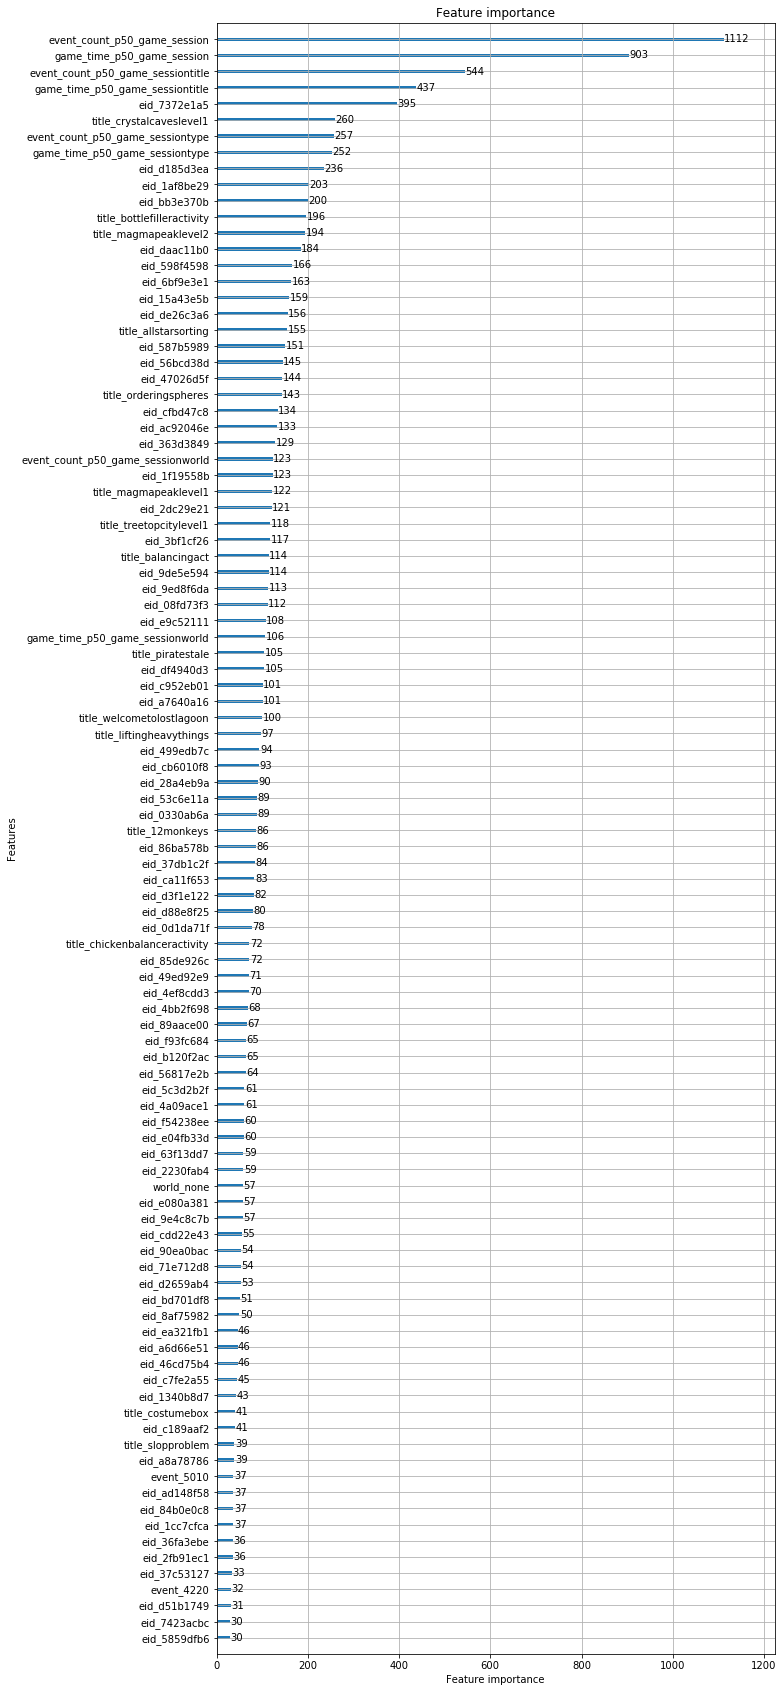

In [60]:
lgb.plot_importance(cv.best_estimator_['model'], max_num_features=100, figsize=(10, 30))

# Predict out of fold

In [61]:
oof = train[['installation_id']].copy()
oof[TARGET] = cv.predict(x_train)
assert oof[TARGET].min() > -0.5
assert oof[TARGET].max() < 3.5
oof[TARGET] = np.round(oof[TARGET]).astype(int)
oof.head()

,installation_id,accuracy_group
0,0006a69f,2
1,0006c192,2
2,00129856,2
3,001d0ed0,1
4,00225f67,2


In [62]:
score = cohen_kappa_score(oof[TARGET], y_train, weights='quadratic')
_log(f'oof score={score:.5f}')

oof score=0.36395


# Predict on Test set

In [63]:
x_test = test[PREDICTORS]
sub = test[['installation_id']].copy()
sub[TARGET] = cv.predict(x_test)
assert sub[TARGET].min() > -0.5
assert sub[TARGET].max() < 3.5
sub[TARGET] = np.round(sub[TARGET]).astype(int)
sub.head()

,installation_id,accuracy_group
0,00abaee7,1
1,01242218,3
2,017c5718,2
3,01a44906,2
4,01bc6cb6,2


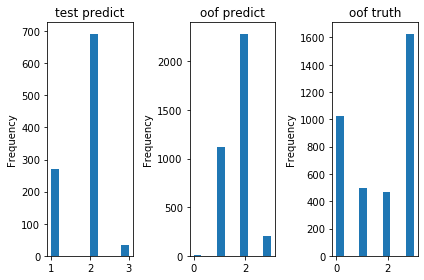

In [64]:
plt.subplot(1, 3, 1)
plt.title('test predict')
sub[TARGET].plot(kind='hist')
plt.subplot(1, 3, 2)
plt.title('oof predict')
oof[TARGET].plot(kind='hist')
plt.subplot(1, 3, 3)
plt.title('oof truth')
tmp = train[TARGET].copy()
tmp = tmp.astype(int)
tmp.plot(kind='hist')
plt.tight_layout()

In [65]:
sub.to_csv('submission.csv', index=False)
_log(os.listdir("."))

['.ipynb_checkpoints', 'dsbowl19-lgb.ipynb', 'dsbowl19-preprocess.ipynb', 'importances-01.png', 'lgbm_importances-01.png', 'submission.csv', 'test.parquet', 'train.parquet']
